# BDE-AT2
## *Author: Vishal Raj*

### Importing Libraries

In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import plotly
import glob
import os
import math
import datetime
import time
import pyspark.sql.functions as F
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
#Storage config & access keys
storage_account_name = "utsvishalraj"
storage_account_access_key = "STORAGE_ACCESS_KEY"
blob_container_name = "bde-at2"
#If it is already mounted, it will skip the step
try:
    dbutils.fs.mount(
        source = f'wasbs://{blob_container_name}@{storage_account_name}.blob.core.windows.net',
        mount_point = f'/mnt/{blob_container_name}/',
        extra_configs = {'fs.azure.account.key.' + storage_account_name + '.blob.core.windows.net': storage_account_access_key}
    )
except:
    pass

In [ ]:
#Listing directories
#%fs ls /

#To remove any temp directories
#%fs rm -r dbfs:/pipeline_save

## Data & Location

In [ ]:
#Storage config & access keys
storage_account_name = "utsvishalraj"
storage_account_access_key = "STORAGE_ACCESS_KEY"
blob_container_name = "bde-at2"

In [ ]:
#If it is already mounted, it will skip the step
try:
    dbutils.fs.mount(
        source = f'wasbs://{blob_container_name}@{storage_account_name}.blob.core.windows.net',
        mount_point = f'/mnt/{blob_container_name}/',
        extra_configs = {'fs.azure.account.key.' + storage_account_name + '.blob.core.windows.net': storage_account_access_key}
    )
except:
    pass

In [ ]:
#Listing the mounts
dbutils.fs.ls("/mnt/bde-at2/")
#dbutils.fs.ls("/mnt/bde-at2/yellow/double")
#dbutils.fs.ls("/mnt/bde-at2/yellow/integer")
#dbutils.fs.ls("/mnt/bde-at2/green")

Out[9]: [FileInfo(path='dbfs:/mnt/bde-at2/all_tripdata/', name='all_tripdata/', size=0, modificationTime=1663984149000),
 FileInfo(path='dbfs:/mnt/bde-at2/green/', name='green/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/mnt/bde-at2/yellow/', name='yellow/', size=0, modificationTime=1664305997000)]

In [ ]:
#Reading the files with double type of "airport_fee" column of yellow colour taxis into a dataframe
basePath='dbfs:/mnt/bde-at2/yellow/double/'
paths=['dbfs:/mnt/bde-at2/yellow/double/yellow*.parquet']
dfd=spark.read.option("basePath",basePath).parquet(*paths)

In [ ]:
#Reading the files with integer type of "airport_fee" column of yellow colour taxis into a dataframe
basePath='dbfs:/mnt/bde-at2/yellow/integer/'
paths=['dbfs:/mnt/bde-at2/yellow/integer/yellow*.parquet']
dfi=spark.read.option("basePath",basePath).parquet(*paths)

In [ ]:
#Casting the integer type column into double
dfi = dfi.withColumn("airport_fee",dfi.airport_fee.cast('double'))
#Combining both dataframes
df1 = dfi.unionByName(dfd)
df1.show()
#Count of rows
yellow_rows = df1.count()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
 1| 2019-03-01 00:24:41| 2019-03-01 00:25:31| 1.0| 0.0| 1.0| N| 145| 145| 2| 2.5| 0.5| 0.5| 0.0| 0.0| 0.3| 3.8| 0.0| null|
 1| 2019-03-01 00:25:27| 2019-03-01 00:36:37| 2.0| 3.7| 1.0| N| 95| 130| 1| 13.0| 0.5| 0.5| 0.7| 0.0| 0.3| 15.0| 0.0| null|
 1| 2019-03-01 00:05:21| 2019-03-01 00:38:23| 1.0| 14.1| 1.0| N| 249| 28| 1| 41.0| 3.0| 0.5| 10.1| 5.76| 0.3| 60.66| 2.5| null|
 1| 2019-03-01 00:48:55| 2019-03-01 01:06:03| 1.0| 9.6| 1.0| N| 138| 98| 2| 27.0| 0.5| 0.5| 0.0| 0.0| 0.3| 28.3| 0.0| null|
 1| 2019-03-01 00:11:42| 2019-03-01 00:16:40| 1.0| 0.8| 1.0| N| 48| 48| 1| 5.5| 3.0| 0.5| 3.0| 0.0| 0.3| 12.3| 2.5| null|
 1| 2019-03-01 00:45:03| 2019-03-01 00:49:38| 1.0| 1.2| 1.0| N| 246| 48| 2| 6.0| 3.0| 0.5| 0.0| 0.0| 0.3| 9.8| 2.5| null|
 1| 2019-03-01 00:02:37| 2019-03-01 00:07:30| 1.0| 0.6| 1.0| Y| 239| 238| 2| 5.5| 3.0| 0.5| 0.0| 0.0| 0.3| 9.3| 2.5| null|
 2| 2019-02-28 19:52:45| 2019-02-28 20:01:54| 1.0| 5.65| 1.0| N| 132| 197| 2| 17.0| 0.5| 0.5| 0.0| 0.0| 0.3| 18.3| 0.0| null|
 2| 2019-03-01 00:14:23| 2019-03-01 00:19:17| 1.0| 1.16| 1.0| N| 229| 170| 1| 6.0| 0.5| 0.5| 2.45| 0.0| 0.3| 12.25| 2.5| null|
 2| 2019-03-01 00:19:09| 2019-03-01 00:23:30| 1.0| 0.71| 1.0| N| 137| 234| 1| 5.0| 0.5| 0.5| 1.0| 0.0| 0.3| 9.8| 2.5| null|
 2| 2019-03-01 00:06:46| 2019-03-01 00:17:09| 5.0| 2.63| 1.0| N| 231| 246| 1| 10.5| 0.5| 0.5| 2.86| 0.0| 0.3| 17.16| 2.5| null|
 1| 2019-03-01 00:00:46| 2019-03-01 00:26:41| 1.0| 5.0| 1.0| N| 230| 7| 3| 20.5| 3.0| 0.5| 0.0| 0.0| 0.3| 24.3| 2.5| null|
 2| 2019-03-01 00:00:40| 2019-03-01 00:49:26| 2.0| 14.04| 1.0| N| 170| 123| 1| 45.5| 0.5| 0.5| 14.79| 0.0| 0.3| 64.09| 2.5| null|
 1| 2019-03-01 00:21:46| 2019-03-01 00:30:25| 1.0| 2.0| 1.0| N| 143| 263| 1| 9.0| 3.0| 0.5| 2.55| 0.0| 0.3| 15.35| 2.5| null|
 2| 2019-03-01 00:25:16| 2019-03-01 00:31:39| 5.0| 2.11| 1.0| N| 229| 236| 1| 8.0| 0.5| 0.5| 2.0| 0.0| 0.3| 13.8| 2.5| null|
 1| 2019-03-01 00:03:09| 2019-03-01 00:49:16| 1.0| 6.8| 1.0| N| 162| 49| 2| 31.5| 3.0| 0.5| 0.0| 0.0| 0.3| 35.3| 2.5| null|
 2| 2019-03-01 00:55:49| 2019-03-01 01:11:06| 1.0| 5.97| 1.0| N| 152| 153| 2| 19.0| 0.5| 0.5| 0.0| 0.0| 0.3| 20.3| 0.0| null|
 1| 2019-03-01 00:35:42| 2019-03-01 00:47:06| 1.0| 3.4| 1.0| N| 162| 74| 1| 12.0| 3.0| 0.5| 1.5| 0.0| 0.3| 17.3| 2.5| null|
 2| 2019-03-01 00:45:03| 2019-03-01 01:14:25| 1.0| 16.89| 2.0| N| 132| 229| 1| 52.0| 0.0| 0.5| 11.06| 0.0| 0.3| 66.36| 2.5| null|
 1| 2019-03-01 00:42:38| 2019-03-01 01:02:58| 1.0| 5.4| 1.0| N| 25| 246| 1| 19.5| 3.0| 0.5| 3.5| 0.0| 0.3| 26.8| 2.5| null|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
only showing top 20 rows

In [ ]:
print("Total number of trips of Yellow Taxis:%.0f" %yellow_rows)

Total number of trips of Yellow Taxis:152823008

In [ ]:
#Reading the files with of green colour taxis into a dataframe
basePath='dbfs:/mnt/bde-at2/green/'
paths=['dbfs:/mnt/bde-at2/green/green*.parquet']
df2=spark.read.option("basePath",basePath).parquet(*paths)

In [ ]:
#View
df2.show()
#Count of rows
green_rows = df2.count()

+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+---------+--------------------+
VendorID|lpep_pickup_datetime|lpep_dropoff_datetime|store_and_fwd_flag|RatecodeID|PULocationID|DOLocationID|passenger_count|trip_distance|fare_amount|extra|mta_tax|tip_amount|tolls_amount|ehail_fee|improvement_surcharge|total_amount|payment_type|trip_type|congestion_surcharge|
+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+---------+--------------------+
 2| 2018-12-21 15:17:29| 2018-12-21 15:18:57| N| 1.0| 264| 264| 5.0| 0.0| 3.0| 0.5| 0.5| 0.0| 0.0| null| 0.3| 4.3| 2.0| 1.0| null|
 2| 2019-01-01 00:10:16| 2019-01-01 00:16:32| N| 1.0| 97| 49| 2.0| 0.86| 6.0| 0.5| 0.5| 0.0| 0.0| null| 0.3| 7.3| 2.0| 1.0| null|
 2| 2019-01-01 00:27:11| 2019-01-01 00:31:38| N| 1.0| 49| 189| 2.0| 0.66| 4.5| 0.5| 0.5| 0.0| 0.0| null| 0.3| 5.8| 1.0| 1.0| null|
 2| 2019-01-01 00:46:20| 2019-01-01 01:04:54| N| 1.0| 189| 17| 2.0| 2.68| 13.5| 0.5| 0.5| 2.96| 0.0| null| 0.3| 19.71| 1.0| 1.0| null|
 2| 2019-01-01 00:19:06| 2019-01-01 00:39:43| N| 1.0| 82| 258| 1.0| 4.53| 18.0| 0.5| 0.5| 0.0| 0.0| null| 0.3| 19.3| 2.0| 1.0| null|
 2| 2019-01-01 00:12:35| 2019-01-01 00:19:09| N| 1.0| 49| 17| 1.0| 1.05| 6.5| 0.5| 0.5| 0.0| 0.0| null| 0.3| 7.8| 1.0| 1.0| null|
 2| 2019-01-01 00:47:55| 2019-01-01 01:00:01| N| 1.0| 255| 33| 1.0| 3.77| 13.5| 0.5| 0.5| 0.0| 0.0| null| 0.3| 14.8| 1.0| 1.0| null|
 1| 2019-01-01 00:12:47| 2019-01-01 00:30:50| N| 1.0| 76| 225| 1.0| 4.1| 16.0| 0.5| 0.5| 0.0| 0.0| null| 0.3| 17.3| 1.0| 1.0| null|
 2| 2019-01-01 00:16:23| 2019-01-01 00:39:46| N| 1.0| 25| 89| 1.0| 7.75| 25.5| 0.5| 0.5| 0.0| 0.0| null| 0.3| 26.8| 1.0| 1.0| null|
 2| 2019-01-01 00:58:02| 2019-01-01 01:19:02| N| 1.0| 85| 39| 1.0| 3.68| 15.5| 0.5| 0.5| 0.0| 0.0| null| 0.3| 16.8| 1.0| 1.0| null|
 2| 2019-01-01 00:37:00| 2019-01-01 00:56:42| N| 1.0| 223| 238| 1.0| 6.84| 22.0| 0.5| 0.5| 8.0| 5.76| null| 0.3| 37.06| 1.0| 1.0| null|
 2| 2019-01-01 00:13:48| 2019-01-01 00:21:00| N| 1.0| 129| 129| 2.0| 1.15| 6.5| 0.5| 0.5| 1.56| 0.0| null| 0.3| 9.36| 1.0| 1.0| null|
 2| 2019-01-01 00:19:59| 2019-01-01 00:45:50| N| 1.0| 71| 71| 1.0| 0.49| 15.5| 0.5| 0.5| 0.0| 0.0| null| 0.3| 16.8| 1.0| 1.0| null|
 2| 2019-01-01 00:57:57| 2019-01-01 01:20:10| N| 1.0| 85| 177| 1.0| 3.61| 17.0| 0.5| 0.5| 0.0| 0.0| null| 0.3| 18.3| 1.0| 1.0| null|
 1| 2019-01-01 00:09:02| 2019-01-01 00:17:50| N| 1.0| 256| 80| 1.0| 1.2| 7.5| 0.5| 0.5| 5.2| 0.0| null| 0.3| 14.0| 1.0| 1.0| null|
 1| 2019-01-01 00:22:12| 2019-01-01 00:25:29| N| 1.0| 80| 80| 1.0| 0.5| 4.0| 0.5| 0.5| 0.0| 0.0| null| 0.3| 5.3| 2.0| 1.0| null|
 1| 2019-01-01 00:31:55| 2019-01-01 00:52:59| N| 1.0| 256| 229| 1.0| 5.5| 19.5| 0.5| 0.5| 4.15| 0.0| null| 0.3| 24.95| 1.0| 1.0| null|
 2| 2019-01-01 00:30:20| 2019-01-01 00:54:19| N| 1.0| 255| 231| 1.0| 5.01| 20.0| 0.5| 0.5| 4.26| 0.0| null| 0.3| 25.56| 1.0| 1.0| null|
 2| 2018-12-31 23:58:06| 2019-01-01 00:00:57| N| 1.0| 146| 7| 1.0| 0.43| 4.0| 0.5| 0.5| 1.06| 0.0| null| 0.3| 6.36| 1.0| 1.0| null|
 2| 2019-01-01 00:40:17| 2019-01-01 00:50:23| N| 1.0| 146| 129| 1.0| 2.72| 10.5| 0.5| 0.5| 2.36| 0.0| null| 0.3| 14.16| 1.0| 1.0| null|
+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+---------+--------------------+
only showing top 20 rows

In [ ]:
print("Total number of trips of Green Taxis:%.0f" %green_rows)

Total number of trips of Green Taxis:9390483

In [ ]:
#Converting the “Yellow” Apr 2022 parquet into a csv file and sending it to Azure Blob Storage
basePath='dbfs:/mnt/bde-at2/yellow/double/'
paths=['dbfs:/mnt/bde-at2/yellow/double/yellow_tripdata_2022-04.parquet']
csv_file=spark.read.option("basePath",basePath).parquet(*paths)
csv_file.write.mode("overwrite").csv('dbfs:/mnt/bde-at2/yellow/double/yellow_tripdata_2022-04')

In [ ]:
#Printing Schema's
df1.printSchema()
df2.printSchema()

root
-- VendorID: long (nullable = true)
-- tpep_pickup_datetime: timestamp (nullable = true)
-- tpep_dropoff_datetime: timestamp (nullable = true)
-- passenger_count: double (nullable = true)
-- trip_distance: double (nullable = true)
-- RatecodeID: double (nullable = true)
-- store_and_fwd_flag: string (nullable = true)
-- PULocationID: long (nullable = true)
-- DOLocationID: long (nullable = true)
-- payment_type: long (nullable = true)
-- fare_amount: double (nullable = true)
-- extra: double (nullable = true)
-- mta_tax: double (nullable = true)
-- tip_amount: double (nullable = true)
-- tolls_amount: double (nullable = true)
-- improvement_surcharge: double (nullable = true)
-- total_amount: double (nullable = true)
-- congestion_surcharge: double (nullable = true)
-- airport_fee: double (nullable = true)

root
-- VendorID: long (nullable = true)
-- lpep_pickup_datetime: timestamp (nullable = true)
-- lpep_dropoff_datetime: timestamp (nullable = true)
-- store_and_fwd_flag: string (nullable = true)
-- RatecodeID: double (nullable = true)
-- PULocationID: long (nullable = true)
-- DOLocationID: long (nullable = true)
-- passenger_count: double (nullable = true)
-- trip_distance: double (nullable = true)
-- fare_amount: double (nullable = true)
-- extra: double (nullable = true)
-- mta_tax: double (nullable = true)
-- tip_amount: double (nullable = true)
-- tolls_amount: double (nullable = true)
-- ehail_fee: double (nullable = true)
-- improvement_surcharge: double (nullable = true)
-- total_amount: double (nullable = true)
-- payment_type: double (nullable = true)
-- trip_type: double (nullable = true)
-- congestion_surcharge: double (nullable = true)

In [ ]:
#Replacing NAs with 0
df1 = df1.na.fill(value=0.0)
df2 = df2.na.fill(value=0.0)

In [ ]:
#Creating temp columns to fix the total_amount
df1 = df1.withColumn("sum1", col("fare_amount")+col("extra")+col("mta_tax")+col("tip_amount")+col("tolls_amount")+col("improvement_surcharge"))
df1 = df1.withColumn("sum2", col("total_amount")+col("airport_fee")+col("congestion_surcharge"))
#Replacing total_amount where airport_fee and congestion_surcharge where not added with the added one
df1 = df1.withColumn('final_sum', F.when(F.col('total_amount') == F.col('sum1'),col("sum2")).otherwise(df1.total_amount))
df1 = df1.drop('total_amount')
df1 = df1.withColumnRenamed("final_sum","total_amount")
df1 = df1.drop('final_sum', 'sum1', 'sum2')

In [ ]:
#Matching the Schema's of both dataframes
df2 = df2.withColumn("payment_type",df2.payment_type.cast('long'))
df1 = df1.withColumnRenamed("tpep_pickup_datetime","pep_pickup_datetime")
df1 = df1.withColumnRenamed("tpep_dropoff_datetime","pep_dropoff_datetime")
df2 = df2.withColumnRenamed("lpep_pickup_datetime","pep_pickup_datetime")
df2 = df2.withColumnRenamed("lpep_dropoff_datetime","pep_dropoff_datetime")
df1 = df1.withColumn("Colour", lit("Yellow"))
df2 = df2.withColumn("Colour", lit("Green"))
df1 = df1.drop('airport_fee')
df2 = df2.drop('ehail_fee','trip_type')

In [ ]:
#Showing both df's
df1.show()

+--------+-------------------+--------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+--------------------+------------+------+
VendorID|pep_pickup_datetime|pep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|congestion_surcharge|total_amount|Colour|
+--------+-------------------+--------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+--------------------+------------+------+
 1|2019-03-01 00:24:41| 2019-03-01 00:25:31| 1.0| 0.0| 1.0| N| 145| 145| 2| 2.5| 0.5| 0.5| 0.0| 0.0| 0.3| 0.0| 3.8|Yellow|
 1|2019-03-01 00:25:27| 2019-03-01 00:36:37| 2.0| 3.7| 1.0| N| 95| 130| 1| 13.0| 0.5| 0.5| 0.7| 0.0| 0.3| 0.0| 15.0|Yellow|
 1|2019-03-01 00:05:21| 2019-03-01 00:38:23| 1.0| 14.1| 1.0| N| 249| 28| 1| 41.0| 3.0| 0.5| 10.1| 5.76| 0.3| 2.5| 63.16|Yellow|
 1|2019-03-01 00:48:55| 2019-03-01 01:06:03| 1.0| 9.6| 1.0| N| 138| 98| 2| 27.0| 0.5| 0.5| 0.0| 0.0| 0.3| 0.0| 28.3|Yellow|
 1|2019-03-01 00:11:42| 2019-03-01 00:16:40| 1.0| 0.8| 1.0| N| 48| 48| 1| 5.5| 3.0| 0.5| 3.0| 0.0| 0.3| 2.5| 14.8|Yellow|
 1|2019-03-01 00:45:03| 2019-03-01 00:49:38| 1.0| 1.2| 1.0| N| 246| 48| 2| 6.0| 3.0| 0.5| 0.0| 0.0| 0.3| 2.5| 12.3|Yellow|
 1|2019-03-01 00:02:37| 2019-03-01 00:07:30| 1.0| 0.6| 1.0| Y| 239| 238| 2| 5.5| 3.0| 0.5| 0.0| 0.0| 0.3| 2.5| 11.8|Yellow|
 2|2019-02-28 19:52:45| 2019-02-28 20:01:54| 1.0| 5.65| 1.0| N| 132| 197| 2| 17.0| 0.5| 0.5| 0.0| 0.0| 0.3| 0.0| 18.3|Yellow|
 2|2019-03-01 00:14:23| 2019-03-01 00:19:17| 1.0| 1.16| 1.0| N| 229| 170| 1| 6.0| 0.5| 0.5| 2.45| 0.0| 0.3| 2.5| 12.25|Yellow|
 2|2019-03-01 00:19:09| 2019-03-01 00:23:30| 1.0| 0.71| 1.0| N| 137| 234| 1| 5.0| 0.5| 0.5| 1.0| 0.0| 0.3| 2.5| 9.8|Yellow|
 2|2019-03-01 00:06:46| 2019-03-01 00:17:09| 5.0| 2.63| 1.0| N| 231| 246| 1| 10.5| 0.5| 0.5| 2.86| 0.0| 0.3| 2.5| 17.16|Yellow|
 1|2019-03-01 00:00:46| 2019-03-01 00:26:41| 1.0| 5.0| 1.0| N| 230| 7| 3| 20.5| 3.0| 0.5| 0.0| 0.0| 0.3| 2.5| 26.8|Yellow|
 2|2019-03-01 00:00:40| 2019-03-01 00:49:26| 2.0| 14.04| 1.0| N| 170| 123| 1| 45.5| 0.5| 0.5| 14.79| 0.0| 0.3| 2.5| 64.09|Yellow|
 1|2019-03-01 00:21:46| 2019-03-01 00:30:25| 1.0| 2.0| 1.0| N| 143| 263| 1| 9.0| 3.0| 0.5| 2.55| 0.0| 0.3| 2.5| 15.35|Yellow|
 2|2019-03-01 00:25:16| 2019-03-01 00:31:39| 5.0| 2.11| 1.0| N| 229| 236| 1| 8.0| 0.5| 0.5| 2.0| 0.0| 0.3| 2.5| 13.8|Yellow|
 1|2019-03-01 00:03:09| 2019-03-01 00:49:16| 1.0| 6.8| 1.0| N| 162| 49| 2| 31.5| 3.0| 0.5| 0.0| 0.0| 0.3| 2.5| 37.8|Yellow|
 2|2019-03-01 00:55:49| 2019-03-01 01:11:06| 1.0| 5.97| 1.0| N| 152| 153| 2| 19.0| 0.5| 0.5| 0.0| 0.0| 0.3| 0.0| 20.3|Yellow|
 1|2019-03-01 00:35:42| 2019-03-01 00:47:06| 1.0| 3.4| 1.0| N| 162| 74| 1| 12.0| 3.0| 0.5| 1.5| 0.0| 0.3| 2.5| 19.8|Yellow|
 2|2019-03-01 00:45:03| 2019-03-01 01:14:25| 1.0| 16.89| 2.0| N| 132| 229| 1| 52.0| 0.0| 0.5| 11.06| 0.0| 0.3| 2.5| 66.36|Yellow|
 1|2019-03-01 00:42:38| 2019-03-01 01:02:58| 1.0| 5.4| 1.0| N| 25| 246| 1| 19.5| 3.0| 0.5| 3.5| 0.0| 0.3| 2.5| 29.3|Yellow|
+--------+-------------------+--------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+--------------------+------------+------+
only showing top 20 rows

In [ ]:
df2.show()

+--------+-------------------+--------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------------------+------------+------------+--------------------+------+
VendorID|pep_pickup_datetime|pep_dropoff_datetime|store_and_fwd_flag|RatecodeID|PULocationID|DOLocationID|passenger_count|trip_distance|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|payment_type|congestion_surcharge|Colour|
+--------+-------------------+--------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------------------+------------+------------+--------------------+------+
 2|2018-12-21 15:17:29| 2018-12-21 15:18:57| N| 1.0| 264| 264| 5.0| 0.0| 3.0| 0.5| 0.5| 0.0| 0.0| 0.3| 4.3| 2| 0.0| Green|
 2|2019-01-01 00:10:16| 2019-01-01 00:16:32| N| 1.0| 97| 49| 2.0| 0.86| 6.0| 0.5| 0.5| 0.0| 0.0| 0.3| 7.3| 2| 0.0| Green|
 2|2019-01-01 00:27:11| 2019-01-01 00:31:38| N| 1.0| 49| 189| 2.0| 0.66| 4.5| 0.5| 0.5| 0.0| 0.0| 0.3| 5.8| 1| 0.0| Green|
 2|2019-01-01 00:46:20| 2019-01-01 01:04:54| N| 1.0| 189| 17| 2.0| 2.68| 13.5| 0.5| 0.5| 2.96| 0.0| 0.3| 19.71| 1| 0.0| Green|
 2|2019-01-01 00:19:06| 2019-01-01 00:39:43| N| 1.0| 82| 258| 1.0| 4.53| 18.0| 0.5| 0.5| 0.0| 0.0| 0.3| 19.3| 2| 0.0| Green|
 2|2019-01-01 00:12:35| 2019-01-01 00:19:09| N| 1.0| 49| 17| 1.0| 1.05| 6.5| 0.5| 0.5| 0.0| 0.0| 0.3| 7.8| 1| 0.0| Green|
 2|2019-01-01 00:47:55| 2019-01-01 01:00:01| N| 1.0| 255| 33| 1.0| 3.77| 13.5| 0.5| 0.5| 0.0| 0.0| 0.3| 14.8| 1| 0.0| Green|
 1|2019-01-01 00:12:47| 2019-01-01 00:30:50| N| 1.0| 76| 225| 1.0| 4.1| 16.0| 0.5| 0.5| 0.0| 0.0| 0.3| 17.3| 1| 0.0| Green|
 2|2019-01-01 00:16:23| 2019-01-01 00:39:46| N| 1.0| 25| 89| 1.0| 7.75| 25.5| 0.5| 0.5| 0.0| 0.0| 0.3| 26.8| 1| 0.0| Green|
 2|2019-01-01 00:58:02| 2019-01-01 01:19:02| N| 1.0| 85| 39| 1.0| 3.68| 15.5| 0.5| 0.5| 0.0| 0.0| 0.3| 16.8| 1| 0.0| Green|
 2|2019-01-01 00:37:00| 2019-01-01 00:56:42| N| 1.0| 223| 238| 1.0| 6.84| 22.0| 0.5| 0.5| 8.0| 5.76| 0.3| 37.06| 1| 0.0| Green|
 2|2019-01-01 00:13:48| 2019-01-01 00:21:00| N| 1.0| 129| 129| 2.0| 1.15| 6.5| 0.5| 0.5| 1.56| 0.0| 0.3| 9.36| 1| 0.0| Green|
 2|2019-01-01 00:19:59| 2019-01-01 00:45:50| N| 1.0| 71| 71| 1.0| 0.49| 15.5| 0.5| 0.5| 0.0| 0.0| 0.3| 16.8| 1| 0.0| Green|
 2|2019-01-01 00:57:57| 2019-01-01 01:20:10| N| 1.0| 85| 177| 1.0| 3.61| 17.0| 0.5| 0.5| 0.0| 0.0| 0.3| 18.3| 1| 0.0| Green|
 1|2019-01-01 00:09:02| 2019-01-01 00:17:50| N| 1.0| 256| 80| 1.0| 1.2| 7.5| 0.5| 0.5| 5.2| 0.0| 0.3| 14.0| 1| 0.0| Green|
 1|2019-01-01 00:22:12| 2019-01-01 00:25:29| N| 1.0| 80| 80| 1.0| 0.5| 4.0| 0.5| 0.5| 0.0| 0.0| 0.3| 5.3| 2| 0.0| Green|
 1|2019-01-01 00:31:55| 2019-01-01 00:52:59| N| 1.0| 256| 229| 1.0| 5.5| 19.5| 0.5| 0.5| 4.15| 0.0| 0.3| 24.95| 1| 0.0| Green|
 2|2019-01-01 00:30:20| 2019-01-01 00:54:19| N| 1.0| 255| 231| 1.0| 5.01| 20.0| 0.5| 0.5| 4.26| 0.0| 0.3| 25.56| 1| 0.0| Green|
 2|2018-12-31 23:58:06| 2019-01-01 00:00:57| N| 1.0| 146| 7| 1.0| 0.43| 4.0| 0.5| 0.5| 1.06| 0.0| 0.3| 6.36| 1| 0.0| Green|
 2|2019-01-01 00:40:17| 2019-01-01 00:50:23| N| 1.0| 146| 129| 1.0| 2.72| 10.5| 0.5| 0.5| 2.36| 0.0| 0.3| 14.16| 1| 0.0| Green|
+--------+-------------------+--------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------------------+------------+------------+--------------------+------+
only showing top 20 rows

In [ ]:
#To avoid double work and to make the notebook more efficient, I combined the data before cleaning it.
#I added the column named 'Colour' to identify whether the data is from 'yellow' or 'green'
df = df1.unionByName(df2)
df.show()

+--------+-------------------+--------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+--------------------+------------+------+
VendorID|pep_pickup_datetime|pep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|congestion_surcharge|total_amount|Colour|
+--------+-------------------+--------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+--------------------+------------+------+
 1|2019-03-01 00:24:41| 2019-03-01 00:25:31| 1.0| 0.0| 1.0| N| 145| 145| 2| 2.5| 0.5| 0.5| 0.0| 0.0| 0.3| 0.0| 3.8|Yellow|
 1|2019-03-01 00:25:27| 2019-03-01 00:36:37| 2.0| 3.7| 1.0| N| 95| 130| 1| 13.0| 0.5| 0.5| 0.7| 0.0| 0.3| 0.0| 15.0|Yellow|
 1|2019-03-01 00:05:21| 2019-03-01 00:38:23| 1.0| 14.1| 1.0| N| 249| 28| 1| 41.0| 3.0| 0.5| 10.1| 5.76| 0.3| 2.5| 63.16|Yellow|
 1|2019-03-01 00:48:55| 2019-03-01 01:06:03| 1.0| 9.6| 1.0| N| 138| 98| 2| 27.0| 0.5| 0.5| 0.0| 0.0| 0.3| 0.0| 28.3|Yellow|
 1|2019-03-01 00:11:42| 2019-03-01 00:16:40| 1.0| 0.8| 1.0| N| 48| 48| 1| 5.5| 3.0| 0.5| 3.0| 0.0| 0.3| 2.5| 14.8|Yellow|
 1|2019-03-01 00:45:03| 2019-03-01 00:49:38| 1.0| 1.2| 1.0| N| 246| 48| 2| 6.0| 3.0| 0.5| 0.0| 0.0| 0.3| 2.5| 12.3|Yellow|
 1|2019-03-01 00:02:37| 2019-03-01 00:07:30| 1.0| 0.6| 1.0| Y| 239| 238| 2| 5.5| 3.0| 0.5| 0.0| 0.0| 0.3| 2.5| 11.8|Yellow|
 2|2019-02-28 19:52:45| 2019-02-28 20:01:54| 1.0| 5.65| 1.0| N| 132| 197| 2| 17.0| 0.5| 0.5| 0.0| 0.0| 0.3| 0.0| 18.3|Yellow|
 2|2019-03-01 00:14:23| 2019-03-01 00:19:17| 1.0| 1.16| 1.0| N| 229| 170| 1| 6.0| 0.5| 0.5| 2.45| 0.0| 0.3| 2.5| 12.25|Yellow|
 2|2019-03-01 00:19:09| 2019-03-01 00:23:30| 1.0| 0.71| 1.0| N| 137| 234| 1| 5.0| 0.5| 0.5| 1.0| 0.0| 0.3| 2.5| 9.8|Yellow|
 2|2019-03-01 00:06:46| 2019-03-01 00:17:09| 5.0| 2.63| 1.0| N| 231| 246| 1| 10.5| 0.5| 0.5| 2.86| 0.0| 0.3| 2.5| 17.16|Yellow|
 1|2019-03-01 00:00:46| 2019-03-01 00:26:41| 1.0| 5.0| 1.0| N| 230| 7| 3| 20.5| 3.0| 0.5| 0.0| 0.0| 0.3| 2.5| 26.8|Yellow|
 2|2019-03-01 00:00:40| 2019-03-01 00:49:26| 2.0| 14.04| 1.0| N| 170| 123| 1| 45.5| 0.5| 0.5| 14.79| 0.0| 0.3| 2.5| 64.09|Yellow|
 1|2019-03-01 00:21:46| 2019-03-01 00:30:25| 1.0| 2.0| 1.0| N| 143| 263| 1| 9.0| 3.0| 0.5| 2.55| 0.0| 0.3| 2.5| 15.35|Yellow|
 2|2019-03-01 00:25:16| 2019-03-01 00:31:39| 5.0| 2.11| 1.0| N| 229| 236| 1| 8.0| 0.5| 0.5| 2.0| 0.0| 0.3| 2.5| 13.8|Yellow|
 1|2019-03-01 00:03:09| 2019-03-01 00:49:16| 1.0| 6.8| 1.0| N| 162| 49| 2| 31.5| 3.0| 0.5| 0.0| 0.0| 0.3| 2.5| 37.8|Yellow|
 2|2019-03-01 00:55:49| 2019-03-01 01:11:06| 1.0| 5.97| 1.0| N| 152| 153| 2| 19.0| 0.5| 0.5| 0.0| 0.0| 0.3| 0.0| 20.3|Yellow|
 1|2019-03-01 00:35:42| 2019-03-01 00:47:06| 1.0| 3.4| 1.0| N| 162| 74| 1| 12.0| 3.0| 0.5| 1.5| 0.0| 0.3| 2.5| 19.8|Yellow|
 2|2019-03-01 00:45:03| 2019-03-01 01:14:25| 1.0| 16.89| 2.0| N| 132| 229| 1| 52.0| 0.0| 0.5| 11.06| 0.0| 0.3| 2.5| 66.36|Yellow|
 1|2019-03-01 00:42:38| 2019-03-01 01:02:58| 1.0| 5.4| 1.0| N| 25| 246| 1| 19.5| 3.0| 0.5| 3.5| 0.0| 0.3| 2.5| 29.3|Yellow|
+--------+-------------------+--------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+--------------------+------------+------+
only showing top 20 rows

In [ ]:
#Checking whether the two dataframes were combined or not
df.select('colour').distinct().show()

+------+
colour|
+------+
Yellow|
 Green|
+------+

In [ ]:
#Printing Schema
df.printSchema()

root
-- VendorID: long (nullable = true)
-- pep_pickup_datetime: timestamp (nullable = true)
-- pep_dropoff_datetime: timestamp (nullable = true)
-- passenger_count: double (nullable = false)
-- trip_distance: double (nullable = false)
-- RatecodeID: double (nullable = false)
-- store_and_fwd_flag: string (nullable = true)
-- PULocationID: long (nullable = true)
-- DOLocationID: long (nullable = true)
-- payment_type: long (nullable = true)
-- fare_amount: double (nullable = false)
-- extra: double (nullable = false)
-- mta_tax: double (nullable = false)
-- tip_amount: double (nullable = false)
-- tolls_amount: double (nullable = false)
-- improvement_surcharge: double (nullable = false)
-- congestion_surcharge: double (nullable = false)
-- total_amount: double (nullable = false)
-- Colour: string (nullable = false)

In [ ]:
#Row count before data cleaning
df.count()

Out[63]: 162213491

In [ ]:
#Filtering number of passengers as maximum passengers allowed is 5
df = df.filter((df.passenger_count < 6) & (df.passenger_count > 0))

In [ ]:
#Filtering datetime to keep the dataset in our required timeline and also removing where dropoff time is less than pickup time
df = df.filter((df.pep_pickup_datetime  < df.pep_dropoff_datetime))
df = df.filter(df.pep_pickup_datetime < ('2022-05-01 00:00:00'))
df = df.filter(df.pep_pickup_datetime > ('2018-12-31 23:59:59'))
df = df.filter(df.pep_dropoff_datetime < ('2022-05-01 10:00:00'))
df = df.filter(df.pep_dropoff_datetime > ('2018-12-31 23:59:59'))

In [ ]:
#Creating columns for trip_times and speeds
from pyspark.sql.functions import col
df = df.withColumn("trip_time_seconds", col("pep_dropoff_datetime").cast("long") - col("pep_pickup_datetime").cast("long"))
df = df.withColumn('trip_time_hours',round(col('trip_time_seconds')/3600, 4))
df = df.withColumn('speed_mph', round(col('trip_distance') / col('trip_time_hours'), 2))
df.show()

+--------+-------------------+--------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+--------------------+------------+------+-----------------+---------------+---------+
VendorID|pep_pickup_datetime|pep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|congestion_surcharge|total_amount|Colour|trip_time_seconds|trip_time_hours|speed_mph|
+--------+-------------------+--------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+--------------------+------------+------+-----------------+---------------+---------+
 1|2019-03-01 00:24:41| 2019-03-01 00:25:31| 1.0| 0.0| 1.0| N| 145| 145| 2| 2.5| 0.5| 0.5| 0.0| 0.0| 0.3| 0.0| 3.8|Yellow| 50| 0.0139| 0.0|
 1|2019-03-01 00:25:27| 2019-03-01 00:36:37| 2.0| 3.7| 1.0| N| 95| 130| 1| 13.0| 0.5| 0.5| 0.7| 0.0| 0.3| 0.0| 15.0|Yellow| 670| 0.1861| 19.88|
 1|2019-03-01 00:05:21| 2019-03-01 00:38:23| 1.0| 14.1| 1.0| N| 249| 28| 1| 41.0| 3.0| 0.5| 10.1| 5.76| 0.3| 2.5| 63.16|Yellow| 1982| 0.5506| 25.61|
 1|2019-03-01 00:48:55| 2019-03-01 01:06:03| 1.0| 9.6| 1.0| N| 138| 98| 2| 27.0| 0.5| 0.5| 0.0| 0.0| 0.3| 0.0| 28.3|Yellow| 1028| 0.2856| 33.61|
 1|2019-03-01 00:11:42| 2019-03-01 00:16:40| 1.0| 0.8| 1.0| N| 48| 48| 1| 5.5| 3.0| 0.5| 3.0| 0.0| 0.3| 2.5| 14.8|Yellow| 298| 0.0828| 9.66|
 1|2019-03-01 00:45:03| 2019-03-01 00:49:38| 1.0| 1.2| 1.0| N| 246| 48| 2| 6.0| 3.0| 0.5| 0.0| 0.0| 0.3| 2.5| 12.3|Yellow| 275| 0.0764| 15.71|
 1|2019-03-01 00:02:37| 2019-03-01 00:07:30| 1.0| 0.6| 1.0| Y| 239| 238| 2| 5.5| 3.0| 0.5| 0.0| 0.0| 0.3| 2.5| 11.8|Yellow| 293| 0.0814| 7.37|
 2|2019-02-28 19:52:45| 2019-02-28 20:01:54| 1.0| 5.65| 1.0| N| 132| 197| 2| 17.0| 0.5| 0.5| 0.0| 0.0| 0.3| 0.0| 18.3|Yellow| 549| 0.1525| 37.05|
 2|2019-03-01 00:14:23| 2019-03-01 00:19:17| 1.0| 1.16| 1.0| N| 229| 170| 1| 6.0| 0.5| 0.5| 2.45| 0.0| 0.3| 2.5| 12.25|Yellow| 294| 0.0817| 14.2|
 2|2019-03-01 00:19:09| 2019-03-01 00:23:30| 1.0| 0.71| 1.0| N| 137| 234| 1| 5.0| 0.5| 0.5| 1.0| 0.0| 0.3| 2.5| 9.8|Yellow| 261| 0.0725| 9.79|
 2|2019-03-01 00:06:46| 2019-03-01 00:17:09| 5.0| 2.63| 1.0| N| 231| 246| 1| 10.5| 0.5| 0.5| 2.86| 0.0| 0.3| 2.5| 17.16|Yellow| 623| 0.1731| 15.19|
 1|2019-03-01 00:00:46| 2019-03-01 00:26:41| 1.0| 5.0| 1.0| N| 230| 7| 3| 20.5| 3.0| 0.5| 0.0| 0.0| 0.3| 2.5| 26.8|Yellow| 1555| 0.4319| 11.58|
 2|2019-03-01 00:00:40| 2019-03-01 00:49:26| 2.0| 14.04| 1.0| N| 170| 123| 1| 45.5| 0.5| 0.5| 14.79| 0.0| 0.3| 2.5| 64.09|Yellow| 2926| 0.8128| 17.27|
 1|2019-03-01 00:21:46| 2019-03-01 00:30:25| 1.0| 2.0| 1.0| N| 143| 263| 1| 9.0| 3.0| 0.5| 2.55| 0.0| 0.3| 2.5| 15.35|Yellow| 519| 0.1442| 13.87|
 2|2019-03-01 00:25:16| 2019-03-01 00:31:39| 5.0| 2.11| 1.0| N| 229| 236| 1| 8.0| 0.5| 0.5| 2.0| 0.0| 0.3| 2.5| 13.8|Yellow| 383| 0.1064| 19.83|
 1|2019-03-01 00:03:09| 2019-03-01 00:49:16| 1.0| 6.8| 1.0| N| 162| 49| 2| 31.5| 3.0| 0.5| 0.0| 0.0| 0.3| 2.5| 37.8|Yellow| 2767| 0.7686| 8.85|
 2|2019-03-01 00:55:49| 2019-03-01 01:11:06| 1.0| 5.97| 1.0| N| 152| 153| 2| 19.0| 0.5| 0.5| 0.0| 0.0| 0.3| 0.0| 20.3|Yellow| 917| 0.2547| 23.44|
 1|2019-03-01 00:35:42| 2019-03-01 00:47:06| 1.0| 3.4| 1.0| N| 162| 74| 1| 12.0| 3.0| 0.5| 1.5| 0.0| 0.3| 2.5| 19.8|Yellow| 684| 0.19| 17.89|
 2|2019-03-01 00:45:03| 2019-03-01 01:14:25| 1.0| 16.89| 2.0| N| 132| 229| 1| 52.0| 0.0| 0.5| 11.06| 0.0| 0.3| 2.5| 66.36|Yellow| 1762| 0.4894| 34.51|
 1|2019-03-01 00:42:38| 2019-03-01 01:02:58| 1.0| 5.4| 1.0| N| 25| 246| 1| 19.5| 3.0| 0.5| 3.5| 0.0| 0.3| 2.5| 29.3|Yellow| 1220| 0.3389| 15.93|
+--------+-------------------+--------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------

In [ ]:
#Viewing max of a column
df.select(max("fare_amount")).show(truncate=False)

+----------------+
max(fare_amount)|
+----------------+
998310.03 |
+----------------+

Data filtering by fare amount & total amount

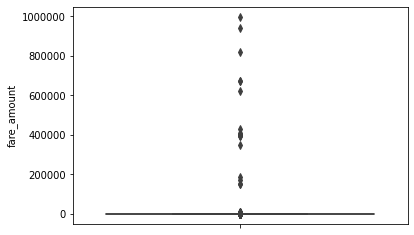

In [ ]:
#Plotting boxplot
df_fare_amount = df.select('fare_amount')
pdDF = df_fare_amount.toPandas()
sns.boxplot(y="fare_amount", data = pdDF)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.show()

In [ ]:
#From the box plot we can see that fare amount above 5000 are major outliers
df = df.filter((df.fare_amount  < 5000) & (df.fare_amount  >= 2.5))

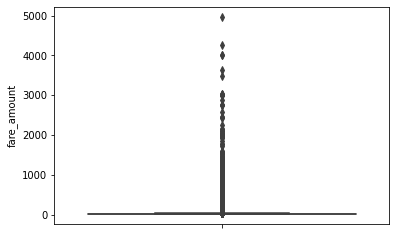

In [ ]:
#Plotting boxplot
df_fare_amount = df.select('fare_amount')
pdDF = df_fare_amount.toPandas()
sns.boxplot(y="fare_amount", data = pdDF)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.show()

In [ ]:
#Removing more impossible outliers
df = df.filter((df.fare_amount  < 2000))

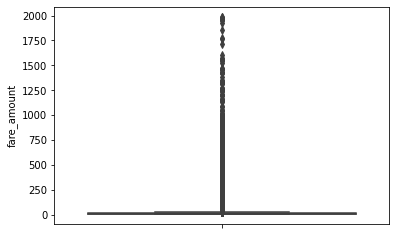

In [ ]:
#Plotting boxplot
df_fare_amount = df.select('fare_amount')
pdDF = df_fare_amount.toPandas()
sns.boxplot(y="fare_amount", data = pdDF)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.show()

In [ ]:
#Calculating 0-100th percentile to find the correct percentile value for the removal of outliers
percentile = df.agg(F.expr('percentile(fare_amount, array(0.10))')[0].alias('%10'),
                             F.expr('percentile(fare_amount, array(0.20))')[0].alias('%20'),
                             F.expr('percentile(fare_amount, array(0.30))')[0].alias('%30'),
                             F.expr('percentile(fare_amount, array(0.40))')[0].alias('%40'),
                             F.expr('percentile(fare_amount, array(0.50))')[0].alias('%50'),
                             F.expr('percentile(fare_amount, array(0.60))')[0].alias('%60'),
                             F.expr('percentile(fare_amount, array(0.70))')[0].alias('%70'),
                             F.expr('percentile(fare_amount, array(0.80))')[0].alias('%80'),
                             F.expr('percentile(fare_amount, array(0.90))')[0].alias('%90'),
                             F.expr('percentile(fare_amount, array(0.90))')[0].alias('%91'),
                             F.expr('percentile(fare_amount, array(0.90))')[0].alias('%92'),
                             F.expr('percentile(fare_amount, array(0.90))')[0].alias('%93'),
                             F.expr('percentile(fare_amount, array(0.90))')[0].alias('%94'),
                             F.expr('percentile(fare_amount, array(0.90))')[0].alias('%95'),
                             F.expr('percentile(fare_amount, array(0.90))')[0].alias('%96'),
                             F.expr('percentile(fare_amount, array(0.90))')[0].alias('%97'),
                             F.expr('percentile(fare_amount, array(0.90))')[0].alias('%98'),
                             F.expr('percentile(fare_amount, array(0.99))')[0].alias('%99'),
                             F.expr('percentile(fare_amount, array(1.00))')[0].alias('%100'))
percentile.show()

+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+------+
%10|%20|%30|%40|%50| %60| %70| %80| %90| %91| %92| %93| %94| %95| %96| %97| %98| %99| %100|
+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+------+
5.0|6.0|7.0|8.0|9.5|11.0|13.0|16.5|25.0|25.0|25.0|25.0|25.0|25.0|25.0|25.0|25.0|52.0|1988.5|
+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+------+

In [ ]:
#Looking further from the 99th percentile
percentile = df.agg(F.expr('percentile(fare_amount, array(0.99))')[0].alias('%99.0'),
                             F.expr('percentile(fare_amount, array(0.991))')[0].alias('%99.1'),
                             F.expr('percentile(fare_amount, array(0.992))')[0].alias('%99.2'),
                             F.expr('percentile(fare_amount, array(0.993))')[0].alias('%99.3'),
                             F.expr('percentile(fare_amount, array(0.994))')[0].alias('%99.4'),
                             F.expr('percentile(fare_amount, array(0.995))')[0].alias('%99.5'),
                             F.expr('percentile(fare_amount, array(0.996))')[0].alias('%99.6'),
                             F.expr('percentile(fare_amount, array(0.997))')[0].alias('%99.7'),
                             F.expr('percentile(fare_amount, array(0.998))')[0].alias('%99.8'),
                             F.expr('percentile(fare_amount, array(0.999))')[0].alias('%99.9'),
                             F.expr('percentile(fare_amount, array(0.9991))')[0].alias('%99.91'),
                             F.expr('percentile(fare_amount, array(0.9992))')[0].alias('%99.92'),
                             F.expr('percentile(fare_amount, array(0.9993))')[0].alias('%99.93'),
                             F.expr('percentile(fare_amount, array(0.9994))')[0].alias('%99.94'),
                             F.expr('percentile(fare_amount, array(0.9995))')[0].alias('%99.95'),
                             F.expr('percentile(fare_amount, array(0.9996))')[0].alias('%99.96'),
                             F.expr('percentile(fare_amount, array(0.9997))')[0].alias('%99.97'),
                             F.expr('percentile(fare_amount, array(0.9998))')[0].alias('%99.98'),
                             F.expr('percentile(fare_amount, array(0.9999))')[0].alias('%99.99'),
                             F.expr('percentile(fare_amount, array(1.00))')[0].alias('%100'))
percentile.show()

+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+------+------+------+------+------+------+------+------+------+
%99.0|%99.1|%99.2|%99.3|%99.4|%99.5|%99.6|%99.7|%99.8|%99.9|%99.91|%99.92|%99.93|%99.94|%99.95|%99.96|%99.97|%99.98|%99.99| %100|
+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+------+------+------+------+------+------+------+------+------+
 52.0| 53.5| 55.5| 58.5| 61.5| 65.0| 67.0| 71.0| 77.5| 97.0| 100.0| 105.0| 111.0| 118.5| 125.0| 135.0| 150.0| 170.0| 211.0|1988.5|
+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+------+------+------+------+------+------+------+------+------+

In [ ]:
#Removing more impossible outliers
#The 99.99th percentile is ~$200, thus we will take 99.99th percentile maximum.
df = df.filter((df.fare_amount < 200))

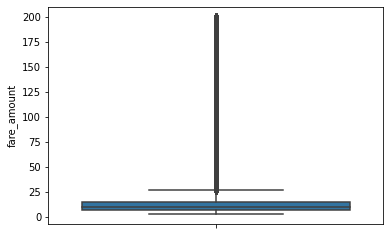

In [ ]:
#Plotting boxplot
df_fare_amount = df.select('fare_amount')
pdDF = df_fare_amount.toPandas()
sns.boxplot(y="fare_amount", data = pdDF)
plt.show()

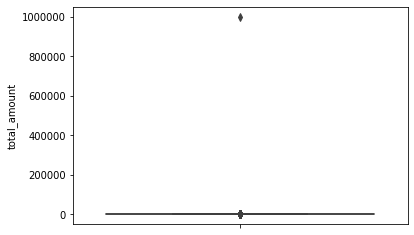

In [ ]:
#Plotting boxplot
df_fare_amount = df.select('total_amount')
pdDF = df_fare_amount.toPandas()
sns.boxplot(y="total_amount", data = pdDF)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.show()

In [ ]:
#Since we are taking $200 as fare amount, we can take the total amount as $300 which includes tips, extra, toll amounts, etc.
df = df.filter((df.total_amount < 300) & (df.total_amount >= 2.5))

In [ ]:
#Removing more impossible outliers
df = df.filter((df.tip_amount < 300) & (df.tip_amount >= 0))
df = df.filter((df.congestion_surcharge < 3) & (df.congestion_surcharge >= 0))
#According to New York State toll rates, maximum can be 90 when using an E-Z pass
df = df.filter((df.tolls_amount < 91) & (df.tolls_amount >= 0))
df = df.filter((df.improvement_surcharge < 0.4) & (df.improvement_surcharge >= 0))
df = df.filter((df.mta_tax < 0.6) & (df.mta_tax >= 0))
df = df.filter((df.extra < 10) & (df.extra >= 0))
#Removing insignificant RateCodeID
df = df.withColumn("RatecodeID",df.RatecodeID.cast('long'))
rcid=["1","2","3","4","5","6"]
df = df.filter(df.RatecodeID.isin(rcid))
#Removing insignificant payment types
df = df.withColumn("payment_type",df.payment_type.cast('long'))
pt=["1","2","5"]
df = df.filter(df.payment_type.isin(pt))

Data filtering by trip time

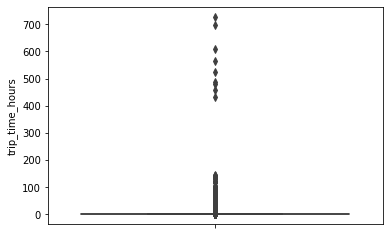

In [ ]:
#Plotting boxplot
df_trip_time_hours = df.select('trip_time_hours')
pdDF1 = df_trip_time_hours.toPandas()
sns.boxplot(y="trip_time_hours", data = pdDF1)
plt.show()

In [ ]:
#Calculating 0-100th percentile to find the correct percentile value for the removal of outliers
percentile = df.agg(F.expr('percentile(trip_time_hours, array(0.10))')[0].alias('%10'),
                             F.expr('percentile(trip_time_hours, array(0.20))')[0].alias('%20'),
                             F.expr('percentile(trip_time_hours, array(0.30))')[0].alias('%30'),
                             F.expr('percentile(trip_time_hours, array(0.40))')[0].alias('%40'),
                             F.expr('percentile(trip_time_hours, array(0.50))')[0].alias('%50'),
                             F.expr('percentile(trip_time_hours, array(0.60))')[0].alias('%60'),
                             F.expr('percentile(trip_time_hours, array(0.70))')[0].alias('%70'),
                             F.expr('percentile(trip_time_hours, array(0.80))')[0].alias('%80'),
                             F.expr('percentile(trip_time_hours, array(0.90))')[0].alias('%90'),
                             F.expr('percentile(trip_time_hours, array(0.90))')[0].alias('%91'),
                             F.expr('percentile(trip_time_hours, array(0.90))')[0].alias('%92'),
                             F.expr('percentile(trip_time_hours, array(0.90))')[0].alias('%93'),
                             F.expr('percentile(trip_time_hours, array(0.90))')[0].alias('%94'),
                             F.expr('percentile(trip_time_hours, array(0.90))')[0].alias('%95'),
                             F.expr('percentile(trip_time_hours, array(0.90))')[0].alias('%96'),
                             F.expr('percentile(trip_time_hours, array(0.90))')[0].alias('%97'),
                             F.expr('percentile(trip_time_hours, array(0.90))')[0].alias('%98'),
                             F.expr('percentile(trip_time_hours, array(0.99))')[0].alias('%99'),
                             F.expr('percentile(trip_time_hours, array(1.00))')[0].alias('%100'))
percentile.show()

+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+--------+
 %10| %20| %30| %40| %50| %60| %70| %80| %90| %91| %92| %93| %94| %95| %96| %97| %98| %99| %100|
+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+--------+
0.0689|0.0972|0.1242|0.1522|0.1833|0.2206|0.2678|0.3361|0.4611|0.4611|0.4611|0.4611|0.4611|0.4611|0.4611|0.4611|0.4611|1.0219|727.4669|
+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+--------+

In [ ]:
#Looking further from the 99th percecntile
percentile = df.agg(F.expr('percentile(trip_time_hours, array(0.99))')[0].alias('%99.0'),
                             F.expr('percentile(trip_time_hours, array(0.991))')[0].alias('%99.1'),
                             F.expr('percentile(trip_time_hours, array(0.992))')[0].alias('%99.2'),
                             F.expr('percentile(trip_time_hours, array(0.993))')[0].alias('%99.3'),
                             F.expr('percentile(trip_time_hours, array(0.994))')[0].alias('%99.4'),
                             F.expr('percentile(trip_time_hours, array(0.995))')[0].alias('%99.5'),
                             F.expr('percentile(trip_time_hours, array(0.996))')[0].alias('%99.6'),
                             F.expr('percentile(trip_time_hours, array(0.997))')[0].alias('%99.7'),
                             F.expr('percentile(trip_time_hours, array(0.998))')[0].alias('%99.8'),
                             F.expr('percentile(trip_time_hours, array(0.999))')[0].alias('%99.9'),
                             F.expr('percentile(trip_time_hours, array(0.9971))')[0].alias('%99.71'),
                             F.expr('percentile(trip_time_hours, array(0.9972))')[0].alias('%99.72'),
                             F.expr('percentile(trip_time_hours, array(0.9973))')[0].alias('%99.73'),
                             F.expr('percentile(trip_time_hours, array(0.9974))')[0].alias('%99.74'),
                             F.expr('percentile(trip_time_hours, array(0.9975))')[0].alias('%99.75'),
                             F.expr('percentile(trip_time_hours, array(0.9976))')[0].alias('%99.76'),
                             F.expr('percentile(trip_time_hours, array(0.9977))')[0].alias('%99.77'),
                             F.expr('percentile(trip_time_hours, array(0.9978))')[0].alias('%99.78'),
                             F.expr('percentile(trip_time_hours, array(0.9979))')[0].alias('%99.79'),
                             F.expr('percentile(trip_time_hours, array(0.9980))')[0].alias('%99.80'),
                             F.expr('percentile(trip_time_hours, array(1.00))')[0].alias('%100'))
percentile.show()

+------+------+------+------+------+------+------+------+-------+-------+------+------+------+------+------+-----------------+------------------+------------------+-------+-------+--------+
 %99.0| %99.1| %99.2| %99.3| %99.4| %99.5| %99.6| %99.7| %99.8| %99.9|%99.71|%99.72|%99.73|%99.74|%99.75| %99.76| %99.77| %99.78| %99.79| %99.80| %100|
+------+------+------+------+------+------+------+------+-------+-------+------+------+------+------+------+-----------------+------------------+------------------+-------+-------+--------+
1.0219|1.0536|1.0903|1.1336|1.1872|1.2578|1.3619|1.5875|23.1283|23.7422|1.6356|1.6989|1.7967|1.9764|2.5261|5.888756960010529|10.836775349998476|19.909543880003692|22.9983|23.1283|727.4669|
+------+------+------+------+------+------+------+------+-------+-------+------+------+------+------+------+-----------------+------------------+------------------+-------+-------+--------+

In [ ]:
#According to NYC Taxi & Limousine Commision Regulations, the maximum trip duration allowed in a 24 hour interval is 10 hours 
#and also the 99.75th percentile is ~2 hours and 99.76th percentile jumps to ~6 hours, thus we will take 6 hrs maximum, which is 21,600 seconds.
#We will also remove negative trip duration.
df = df.filter((df.trip_time_seconds  < 21600) & (df.trip_time_seconds  > 120))

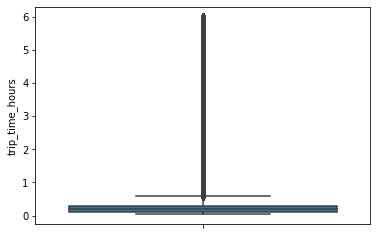

In [ ]:
#Plotting boxplot
df_trip_time_hours = df.select('trip_time_hours')
pdDF1 = df_trip_time_hours.toPandas()
sns.boxplot(y="trip_time_hours", data = pdDF1)
plt.show()

Data filtering by speed

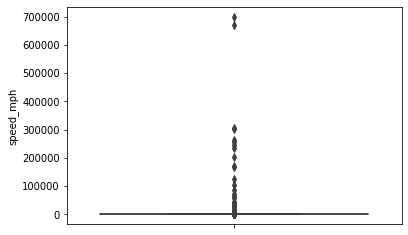

In [ ]:
#Plotting boxplot
df_speed_mph = df.select('speed_mph')
pdDF2 = df_speed_mph.toPandas()
sns.boxplot(y="speed_mph", data = pdDF2)
plt.show()

In [ ]:
#Calculating 0-100th percentile to find the correct percentile value for the removal of outliers
percentile = df.agg(F.expr('percentile(speed_mph, array(0.10))')[0].alias('%10'),
                             F.expr('percentile(speed_mph, array(0.20))')[0].alias('%20'),
                             F.expr('percentile(speed_mph, array(0.30))')[0].alias('%30'),
                             F.expr('percentile(speed_mph, array(0.40))')[0].alias('%40'),
                             F.expr('percentile(speed_mph, array(0.50))')[0].alias('%50'),
                             F.expr('percentile(speed_mph, array(0.60))')[0].alias('%60'),
                             F.expr('percentile(speed_mph, array(0.70))')[0].alias('%70'),
                             F.expr('percentile(speed_mph, array(0.80))')[0].alias('%80'),
                             F.expr('percentile(speed_mph, array(0.90))')[0].alias('%90'),
                             F.expr('percentile(speed_mph, array(0.90))')[0].alias('%91'),
                             F.expr('percentile(speed_mph, array(0.90))')[0].alias('%92'),
                             F.expr('percentile(speed_mph, array(0.90))')[0].alias('%93'),
                             F.expr('percentile(speed_mph, array(0.90))')[0].alias('%94'),
                             F.expr('percentile(speed_mph, array(0.90))')[0].alias('%95'),
                             F.expr('percentile(speed_mph, array(0.90))')[0].alias('%96'),
                             F.expr('percentile(speed_mph, array(0.90))')[0].alias('%97'),
                             F.expr('percentile(speed_mph, array(0.90))')[0].alias('%98'),
                             F.expr('percentile(speed_mph, array(0.99))')[0].alias('%99'),
                             F.expr('percentile(speed_mph, array(1.00))')[0].alias('%100'))
percentile.show()

+---+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+---------+
%10| %20| %30| %40| %50| %60| %70| %80| %90| %91| %92| %93| %94| %95| %96| %97| %98| %99| %100|
+---+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+---------+
5.8|7.14|8.19|9.17|10.18|11.33|12.77|14.93|19.23|19.23|19.23|19.23|19.23|19.23|19.23|19.23|19.23|35.0|699175.29|
+---+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+---------+

In [ ]:
#Looking further from the 98th percecntile
percentile = df.agg(F.expr('percentile(speed_mph, array(0.98))')[0].alias('%98.0'),
                             F.expr('percentile(speed_mph, array(0.981))')[0].alias('%98.1'),
                             F.expr('percentile(speed_mph, array(0.982))')[0].alias('%98.2'),
                             F.expr('percentile(speed_mph, array(0.983))')[0].alias('%98.3'),
                             F.expr('percentile(speed_mph, array(0.984))')[0].alias('%98.4'),
                             F.expr('percentile(speed_mph, array(0.985))')[0].alias('%98.5'),
                             F.expr('percentile(speed_mph, array(0.986))')[0].alias('%98.6'),
                             F.expr('percentile(speed_mph, array(0.987))')[0].alias('%98.7'),
                             F.expr('percentile(speed_mph, array(0.988))')[0].alias('%98.8'),
                             F.expr('percentile(speed_mph, array(0.989))')[0].alias('%98.9'),
                             F.expr('percentile(speed_mph, array(0.9991))')[0].alias('%99.91'),
                             F.expr('percentile(speed_mph, array(0.9992))')[0].alias('%99.92'),
                             F.expr('percentile(speed_mph, array(0.9993))')[0].alias('%99.93'),
                             F.expr('percentile(speed_mph, array(0.9994))')[0].alias('%99.94'),
                             F.expr('percentile(speed_mph, array(0.9995))')[0].alias('%99.95'),
                             F.expr('percentile(speed_mph, array(0.9996))')[0].alias('%99.96'),
                             F.expr('percentile(speed_mph, array(0.9997))')[0].alias('%99.97'),
                             F.expr('percentile(speed_mph, array(0.9998))')[0].alias('%99.98'),
                             F.expr('percentile(speed_mph, array(0.9999))')[0].alias('%99.99'),
                             F.expr('percentile(speed_mph, array(1.00))')[0].alias('%100'))
percentile.show()

+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+------+------+------+------+------+------+------+------+---------+
%98.0|%98.1|%98.2|%98.3|%98.4|%98.5|%98.6|%98.7|%98.8|%98.9|%99.91|%99.92|%99.93|%99.94|%99.95|%99.96|%99.97|%99.98|%99.99| %100|
+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+------+------+------+------+------+------+------+------+---------+
30.58|30.93| 31.3|31.67|32.07|32.49|32.93| 33.4| 33.9|34.43| 45.99| 46.43| 46.93| 47.51| 48.21| 49.09| 50.32| 52.46| 60.91|699175.29|
+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+------+------+------+------+------+------+------+------+---------+

In [ ]:
#According to NYC Speed Limit, the maximum speed allowed is 50-55 in the NYC
#And also the 99th percentile is ~45 mph, thus we will take 99th percentile maximum as no vehicle can always run at maximum speed limit.
#We do have to consider traffic, stops, traffic lights, etc. Thus we will take ~35 mph.
#We also assumed 3 mph to be minimum as traffic jams reduce average speed
df = df.filter((df.speed_mph  < 35) & (df.speed_mph  > 3))

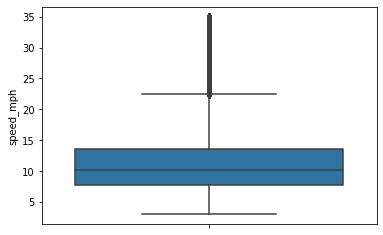

In [ ]:
#Plotting boxplot
df_speed_mph = df.select('speed_mph')
pdDF2 = df_speed_mph.toPandas()
sns.boxplot(y="speed_mph", data = pdDF2)
plt.show()

Data filtering by trip distance

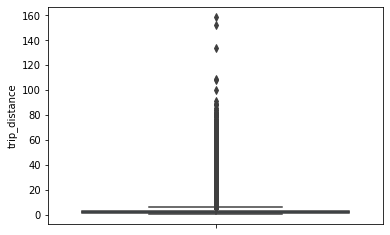

In [ ]:
#Plotting boxplot
df_trip_distance = df.select('trip_distance')
pdDF3 = df_trip_distance.toPandas()
sns.boxplot(y="trip_distance", data = pdDF3)
plt.show()

In [ ]:
#Calculating 0-100th percentile to find the correct percentile value for the removal of outliers
percentile = df.agg(F.expr('percentile(trip_distance, array(0.05))')[0].alias('%5'),
                             F.expr('percentile(trip_distance, array(0.10))')[0].alias('%10'),
                             F.expr('percentile(trip_distance, array(0.20))')[0].alias('%20'),
                             F.expr('percentile(trip_distance, array(0.30))')[0].alias('%30'),
                             F.expr('percentile(trip_distance, array(0.40))')[0].alias('%40'),
                             F.expr('percentile(trip_distance, array(0.50))')[0].alias('%50'),
                             F.expr('percentile(trip_distance, array(0.60))')[0].alias('%60'),
                             F.expr('percentile(trip_distance, array(0.70))')[0].alias('%70'),
                             F.expr('percentile(trip_distance, array(0.80))')[0].alias('%80'),
                             F.expr('percentile(trip_distance, array(0.90))')[0].alias('%90'),
                             F.expr('percentile(trip_distance, array(0.91))')[0].alias('%91'),
                             F.expr('percentile(trip_distance, array(0.92))')[0].alias('%92'),
                             F.expr('percentile(trip_distance, array(0.93))')[0].alias('%93'),
                             F.expr('percentile(trip_distance, array(0.94))')[0].alias('%94'),
                             F.expr('percentile(trip_distance, array(0.95))')[0].alias('%95'),
                             F.expr('percentile(trip_distance, array(0.96))')[0].alias('%96'),
                             F.expr('percentile(trip_distance, array(0.97))')[0].alias('%97'),
                             F.expr('percentile(trip_distance, array(0.98))')[0].alias('%98'),
                             F.expr('percentile(trip_distance, array(0.99))')[0].alias('%99'),
                             F.expr('percentile(trip_distance, array(1.00))')[0].alias('%100'))
percentile.show()

+----+---+----+----+---+---+---+----+----+---+----+----+----+----+-----+-----+-----+----+-----+------+
 %5|%10| %20| %30|%40|%50|%60| %70| %80|%90| %91| %92| %93| %94| %95| %96| %97| %98| %99| %100|
+----+---+----+----+---+---+---+----+----+---+----+----+----+----+-----+-----+-----+----+-----+------+
0.57|0.7|0.93|1.17|1.4|1.7|2.1|2.68|3.67|6.5|7.09|7.79|8.55|9.36|10.25|11.49|13.86|17.1|18.69|158.88|
+----+---+----+----+---+---+---+----+----+---+----+----+----+----+-----+-----+-----+----+-----+------+

In [ ]:
#Looking further from the 98th percecntile
percentile = df.agg(F.expr('percentile(speed_mph, array(0.98))')[0].alias('%98.0'),
                             F.expr('percentile(trip_distance, array(0.981))')[0].alias('%98.1'),
                             F.expr('percentile(trip_distance, array(0.982))')[0].alias('%98.2'),
                             F.expr('percentile(trip_distance, array(0.983))')[0].alias('%98.3'),
                             F.expr('percentile(trip_distance, array(0.984))')[0].alias('%98.4'),
                             F.expr('percentile(trip_distance, array(0.985))')[0].alias('%98.5'),
                             F.expr('percentile(trip_distance, array(0.986))')[0].alias('%98.6'),
                             F.expr('percentile(trip_distance, array(0.987))')[0].alias('%98.7'),
                             F.expr('percentile(trip_distance, array(0.988))')[0].alias('%98.8'),
                             F.expr('percentile(trip_distance, array(0.989))')[0].alias('%98.9'),
                             F.expr('percentile(trip_distance, array(0.9991))')[0].alias('%99.91'),
                             F.expr('percentile(trip_distance, array(0.9992))')[0].alias('%99.92'),
                             F.expr('percentile(trip_distance, array(0.9993))')[0].alias('%99.93'),
                             F.expr('percentile(trip_distance, array(0.9994))')[0].alias('%99.94'),
                             F.expr('percentile(trip_distance, array(0.9995))')[0].alias('%99.95'),
                             F.expr('percentile(trip_distance, array(0.9996))')[0].alias('%99.96'),
                             F.expr('percentile(trip_distance, array(0.9997))')[0].alias('%99.97'),
                             F.expr('percentile(trip_distance, array(0.9998))')[0].alias('%99.98'),
                             F.expr('percentile(trip_distance, array(0.9999))')[0].alias('%99.99'),
                             F.expr('percentile(trip_distance, array(1.00))')[0].alias('%100'))
percentile.show()

+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+------+------+------+------+------+------+------+------+------+
%98.0|%98.1|%98.2|%98.3|%98.4|%98.5|%98.6|%98.7|%98.8|%98.9|%99.91|%99.92|%99.93|%99.94|%99.95|%99.96|%99.97|%99.98|%99.99| %100|
+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+------+------+------+------+------+------+------+------+------+
27.85| 17.3|17.44| 17.6|17.73|17.89|18.01|18.18|18.31| 18.5| 24.8| 25.42| 26.1| 26.75| 27.52| 28.3| 29.2| 30.81| 34.57|158.88|
+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+------+------+------+------+------+------+------+------+------+

In [ ]:
#We see greater jumps starting after 30 miles, therefore let's take the 99.98th percentile, i.e., ~30 miles
#We will also remove negative trip distance.
#We also discarded rows having trip distance less than 5th percentile.
df = df.filter((df.trip_distance  < 30) & (df.trip_distance > 0.5))

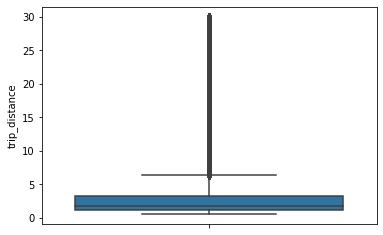

In [ ]:
#Plotting boxplot
df_trip_distance = df.select('trip_distance')
pdDF3 = df_trip_distance.toPandas()
sns.boxplot(y="trip_distance", data = pdDF3)
plt.show()

In [ ]:
#Row count after data cleaning
df.count()

Out[75]: 137630951

In [ ]:
#Writing the dataframe as parquet file in the azure blob storage and reading and saving it as table
df.repartition(1).write.mode("overwrite").format('parquet').save('dbfs:/mnt/bde-at2/all_tripdata')
data = spark.read.parquet("dbfs:/mnt/bde-at2/all_tripdata/*.parquet")
data.write.mode("overwrite").saveAsTable("trip_data")

In [ ]:
data = spark.read.parquet("dbfs:/mnt/bde-at2/all_tripdata/*.parquet")
data.write.mode("overwrite").saveAsTable("trip_data")

## Part 2

### Question 1
For each year and month (e.g January 2020 => “2020-01-01” or “2020-01” or “Jan 2020”): <br>
a.	What was the total number of trips? <br>
b.	Which day of week (e.g. monday, tuesday, etc..) had the most trips? <br>
c.	Which hour of the day had the most trips? <br>
d.	What was the average number of passengers? <br>
e.	What was the average amount paid per trip (using total_amount)? <br>
f.	What was the average amount paid per passenger (using total_amount)? <br>


In [ ]:
%sql
WITH CTE1 AS(
  SELECT DATE_TRUNC('month', pep_pickup_datetime) AS Year_Month,
       CASE (DAYOFWEEK(pep_pickup_datetime))
           WHEN 1 THEN 'Sunday' 
           WHEN 2 THEN 'Monday' 
           WHEN 3 THEN 'Tuesday' 
           WHEN 4 THEN 'Wednesday' 
           WHEN 5 THEN 'Thursday' 
           WHEN 6 THEN 'Friday' 
           WHEN 7 THEN 'Saturday' 
       END AS Week_day,
  HOUR(pep_pickup_datetime) AS Hour_of_the_Day,
  ROUND(AVG(passenger_count), 2) AS Avg_Passenger_Count,
  ROUND(AVG(total_amount), 2) AS Avg_amount_paid_per_trips,
  ROUND(sum(total_amount)/sum(passenger_count), 2) AS Avg_amount_paid_per_passengers,
  COUNT(*) AS No_of_Trips
  FROM trip_data
  GROUP BY Year_Month, Week_day, Hour_of_the_Day
  ORDER BY Year_Month),
CTE2 AS(
  SELECT Year_Month, No_of_Trips, Week_day, Hour_of_the_Day,
  Avg_Passenger_Count, Avg_amount_paid_per_trips, Avg_amount_paid_per_passengers,
  rank() OVER (PARTITION BY Year_Month ORDER BY No_of_Trips DESC) AS RK
  FROM CTE1),
CTE3 AS (
  SELECT Year_Month, Week_day, Hour_of_the_Day, Avg_Passenger_Count,
  Avg_amount_paid_per_trips, Avg_amount_paid_per_passengers
  FROM CTE2
  WHERE RK = 1
  ORDER BY Year_Month),
CTE4 AS (
  SELECT DATE_TRUNC('month', pep_pickup_datetime) AS Year_Month, count(*) AS Total_No_of_Trips 
  FROM trip_data
  GROUP BY Year_Month
  ORDER BY Year_Month),
CTE5 AS (
  SELECT cast(cte4.Year_Month AS Date) Year_with_Month, Total_No_of_Trips, Week_day,
  Hour_of_the_Day, Avg_Passenger_Count, Avg_amount_paid_per_trips,
  Avg_amount_paid_per_passengers
  FROM CTE3 INNER JOIN CTE4 ON CTE3.Year_Month = CTE4.Year_Month)
  SELECT DATE_FORMAT(Year_with_Month, 'y-MMMM') AS Year_And_Month, Total_No_of_Trips,
  Week_day, Hour_of_the_Day, Avg_Passenger_Count, Avg_amount_paid_per_trips,
  Avg_amount_paid_per_passengers
  FROM CTE5
  ORDER BY Year_with_Month;

Year_And_Month,Total_No_of_Trips,Week_day,Hour_of_the_Day,Avg_Passenger_Count,Avg_amount_paid_per_trips,Avg_amount_paid_per_passengers
2019-January,7209880,Thursday,18,1.46,16.29,11.19
2019-February,6633721,Friday,18,1.48,19.02,12.89
2019-March,7379936,Friday,18,1.49,19.93,13.39
2019-April,6954116,Tuesday,18,1.47,19.73,13.44
2019-May,7045034,Wednesday,18,1.46,20.44,14.02
2019-June,6466403,Saturday,17,1.56,19.6,12.54
2019-July,5828827,Tuesday,18,1.46,19.87,13.58
2019-August,5610617,Thursday,18,1.47,20.59,14.02
2019-September,6013348,Thursday,19,1.45,20.51,14.12
2019-October,6580364,Wednesday,18,1.45,20.68,14.3


### Question 2
For each taxi colour (yellow and green): <br>
a.	What was the average, median, minimum and maximum trip duration in minutes (with 2 decimals, eg. 90 seconds = 1.50 min)? <br>
b.	What was the average, median, minimum and maximum trip distance in km? <br>
c.	What was the average, median, minimum and maximum speed in km per hour? <br>

In [ ]:
%sql
SELECT colour,
ROUND(AVG(trip_time_seconds/60), 2) AS Average_Trip_Duration,
ROUND(PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY trip_time_seconds/60), 2) AS Median_Trip_Duration,
ROUND(MIN(trip_time_seconds/60), 2) AS Minimum_Trip_Duration,
ROUND(MAX(trip_time_seconds/60), 2) AS Maximum_Trip_Duration,
ROUND(AVG(trip_distance*1.609), 2) AS Average_Trip_Distance_KM,
ROUND(PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY trip_distance*1.609), 2) AS Median_Trip_Distance_KM,
ROUND(MIN(trip_distance*1.609), 2) AS Minimum_Trip_Distance_km,
ROUND(MAX(trip_distance*1.609), 2) AS Maximum_Trip_Distance_KM,
ROUND(AVG(speed_mph*1.609), 2) AS Average_Trip_Speed_KMPH,
ROUND(PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY speed_mph*1.609), 2) AS Median_Trip_Speed_KMPH,
ROUND(MIN(speed_mph*1.609), 2) AS Minimum_Trip_Speed_KMPH,
ROUND(MAX(speed_mph*1.609), 2) AS Maximum_Trip_Speed_KMPH
FROM trip_data
GROUP BY colour;

colour,Average_Trip_Duration,Median_Trip_Duration,Minimum_Trip_Duration,Maximum_Trip_Duration,Average_Trip_Distance_KM,Median_Trip_Distance_KM,Minimum_Trip_Distance_km,Maximum_Trip_Distance_KM,Average_Trip_Speed_KMPH,Median_Trip_Speed_KMPH,Minimum_Trip_Speed_KMPH,Maximum_Trip_Speed_KMPH
Yellow,14.51,11.43,2.02,359.98,4.85,2.86,0.82,48.25,18.63,16.57,4.84,56.3
Green,15.16,11.57,2.02,356.95,5.16,3.22,0.82,48.25,19.47,17.52,4.84,56.3


### Question 3
What was the percentage of trips where drivers received tips?

In [ ]:
%sql
SELECT ROUND((
SELECT COUNT(tip_amount)
FROM trip_data
WHERE tip_amount > 0)
/COUNT(tip_amount)*100, 2) AS Trip_percentage_for_tips
FROM trip_data;

Trip_percentage_for_tips
71.13


### Question 4
For trips where the driver received tips, what was the percentage where the driver received tips of at least $10.

In [ ]:
%sql
SELECT ROUND((
SELECT COUNT(tip_amount)
FROM trip_data
WHERE tip_amount >= 10)
/COUNT(tip_amount)*100, 2) AS Trip_percentage_for_tips_above_$10
FROM trip_data;

Trip_percentage_for_tips_above_
2.23


### Question 5
Classify each trip into bins of durations: <br>
a.	Under 5 Mins <br>
b.	From 5 mins to 10 mins <br>
c.	From 10 mins to 20 mins <br>
d.	From 20 mins to 30 mins <br>
e.	From 30 mins to 60 mins <br>
f.	At least 60 mins <br>

Then for each bins, calculate: <br>
a.	Average speed (km per hour) <br>
b.	Average distance per dollar (km per $) <br>

In [ ]:
%sql
WITH cte1 AS
(
SELECT
     CASE 
        WHEN trip_time_seconds/60 < 5 THEN 'Under_5_mins'
        WHEN trip_time_seconds/60 >= 5 AND trip_time_seconds/60 <= 10 THEN '5_To_10mins'
        WHEN trip_time_seconds/60 > 10 AND trip_time_seconds/60 <= 20 THEN '10_To_20mins'
        WHEN trip_time_seconds/60 > 20 AND trip_time_seconds/60 <= 30 THEN '20_To_30mins'
        WHEN trip_time_seconds/60 > 30 AND trip_time_seconds/60 <= 60 THEN '30_To_60mins'
        WHEN trip_time_seconds/60 >= 60 THEN 'At_least_60mins'
    End as Bins_of_Durations,
    speed_mph, trip_distance, total_amount
FROM
    trip_data)
SELECT
    Bins_of_Durations,
    count(*) AS No_Of_Trips, ROUND((avg(speed_mph)*1.609), 2) as Average_Speed_KMPH,
    ROUND(sum((trip_distance)*1.609)/sum(total_amount), 2) AS Average_Distance_KM_per_Dollar
FROM
    cte1
GROUP BY
    Bins_of_Durations;

Bins_of_Durations,No_Of_Trips,Average_Speed_KMPH,Average_Distance_KM_per_Dollar
At_least_60mins,1147988,23.05,0.39
Under_5_mins,14395296,20.95,0.14
30_To_60mins,10027298,26.34,0.36
20_To_30mins,17109985,20.14,0.29
5_To_10mins,43625032,17.05,0.17
10_To_20mins,51325352,17.33,0.23


## Part 3

In [ ]:
#Printing Schema
df.printSchema()

root
-- VendorID: long (nullable = true)
-- pep_pickup_datetime: timestamp (nullable = true)
-- pep_dropoff_datetime: timestamp (nullable = true)
-- passenger_count: double (nullable = false)
-- trip_distance: double (nullable = false)
-- RatecodeID: long (nullable = true)
-- store_and_fwd_flag: string (nullable = true)
-- PULocationID: long (nullable = true)
-- DOLocationID: long (nullable = true)
-- payment_type: long (nullable = true)
-- fare_amount: double (nullable = false)
-- extra: double (nullable = false)
-- mta_tax: double (nullable = false)
-- tip_amount: double (nullable = false)
-- tolls_amount: double (nullable = false)
-- improvement_surcharge: double (nullable = false)
-- congestion_surcharge: double (nullable = false)
-- total_amount: double (nullable = false)
-- Colour: string (nullable = false)
-- trip_time_seconds: long (nullable = true)
-- trip_time_hours: double (nullable = true)
-- speed_mph: double (nullable = true)

In [ ]:
#Putting the above cleaned dataset into another dataset for further analysis
df_cleaned = df

In [ ]:
#Dropping obvious insignificant columns
df_cleaned = df_cleaned.drop('VendorID', 'store_and_fwd_flag', 'colour')

<span style="background-color: #FFFF00">CODE COMMENTED BELOW, BECAUSE IT TAKES HOURS - OUTPUT ALREADY IN REPORT</span>

In [ ]:
#Variable Importance

#df_cleaned0 = df_cleaned.drop('pep_pickup_datetime', 'pep_dropoff_datetime')
#import six
#for i in df_cleaned0.columns:
#        if not( isinstance(df_cleaned0.select(i).take(11)[0][0], six.string_types)):
#            print( "Correlation to total_amount for ", i, df_cleaned0.stat.corr('total_amount',i))

In [ ]:
#Dropping columns that seemed unimportant from looking at variable importance
df_cleaned = df_cleaned.drop('passenger_count', 'PULocationID', 'DOLocationID', 'payment_type', 'improvement_surcharge', 'congestion_surcharge', 'trip_time_hours', 'fare_amount')

In [ ]:
import pyspark.sql.functions as F
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType

In [ ]:
#Selecting columns for feature setup
df_cleaned1 = df_cleaned.select(col("pep_pickup_datetime"), year(col("pep_pickup_datetime")).alias("year"), month(col("pep_pickup_datetime")).alias("month"),
                                dayofyear(col("pep_pickup_datetime")).alias("day_of_year"), hour(col("pep_pickup_datetime")).alias("hour"),
                                col("RatecodeID"), col("trip_distance"), col("trip_time_seconds"), col("speed_mph"),
                                col("extra"), col("mta_tax"), col("tip_amount"), col("tolls_amount"), col("total_amount"))

In [ ]:
#Printing Schema
df_cleaned1.printSchema()

root
-- pep_pickup_datetime: timestamp (nullable = true)
-- year: integer (nullable = true)
-- month: integer (nullable = true)
-- day_of_year: integer (nullable = true)
-- hour: integer (nullable = true)
-- RatecodeID: long (nullable = true)
-- trip_distance: double (nullable = false)
-- trip_time_seconds: long (nullable = true)
-- speed_mph: double (nullable = true)
-- extra: double (nullable = false)
-- mta_tax: double (nullable = false)
-- tip_amount: double (nullable = false)
-- tolls_amount: double (nullable = false)
-- total_amount: double (nullable = false)

In [ ]:
#Viewing data frame
df_cleaned1.show()

+-------------------+----+-----+-----------+----+----------+-------------+-----------------+---------+-----+-------+----------+------------+------------+
pep_pickup_datetime|year|month|day_of_year|hour|RatecodeID|trip_distance|trip_time_seconds|speed_mph|extra|mta_tax|tip_amount|tolls_amount|total_amount|
+-------------------+----+-----+-----------+----+----------+-------------+-----------------+---------+-----+-------+----------+------------+------------+
2019-03-01 00:25:27|2019| 3| 60| 0| 1| 3.7| 670| 19.88| 0.5| 0.5| 0.7| 0.0| 15.0|
2019-03-01 00:05:21|2019| 3| 60| 0| 1| 14.1| 1982| 25.61| 3.0| 0.5| 10.1| 5.76| 63.16|
2019-03-01 00:48:55|2019| 3| 60| 0| 1| 9.6| 1028| 33.61| 0.5| 0.5| 0.0| 0.0| 28.3|
2019-03-01 00:11:42|2019| 3| 60| 0| 1| 0.8| 298| 9.66| 3.0| 0.5| 3.0| 0.0| 14.8|
2019-03-01 00:45:03|2019| 3| 60| 0| 1| 1.2| 275| 15.71| 3.0| 0.5| 0.0| 0.0| 12.3|
2019-03-01 00:02:37|2019| 3| 60| 0| 1| 0.6| 293| 7.37| 3.0| 0.5| 0.0| 0.0| 11.8|
2019-03-01 00:14:23|2019| 3| 60| 0| 1| 1.16| 294| 14.2| 0.5| 0.5| 2.45| 0.0| 12.25|
2019-03-01 00:19:09|2019| 3| 60| 0| 1| 0.71| 261| 9.79| 0.5| 0.5| 1.0| 0.0| 9.8|
2019-03-01 00:06:46|2019| 3| 60| 0| 1| 2.63| 623| 15.19| 0.5| 0.5| 2.86| 0.0| 17.16|
2019-03-01 00:00:40|2019| 3| 60| 0| 1| 14.04| 2926| 17.27| 0.5| 0.5| 14.79| 0.0| 64.09|
2019-03-01 00:21:46|2019| 3| 60| 0| 1| 2.0| 519| 13.87| 3.0| 0.5| 2.55| 0.0| 15.35|
2019-03-01 00:25:16|2019| 3| 60| 0| 1| 2.11| 383| 19.83| 0.5| 0.5| 2.0| 0.0| 13.8|
2019-03-01 00:03:09|2019| 3| 60| 0| 1| 6.8| 2767| 8.85| 3.0| 0.5| 0.0| 0.0| 37.8|
2019-03-01 00:55:49|2019| 3| 60| 0| 1| 5.97| 917| 23.44| 0.5| 0.5| 0.0| 0.0| 20.3|
2019-03-01 00:35:42|2019| 3| 60| 0| 1| 3.4| 684| 17.89| 3.0| 0.5| 1.5| 0.0| 19.8|
2019-03-01 00:45:03|2019| 3| 60| 0| 2| 16.89| 1762| 34.51| 0.0| 0.5| 11.06| 0.0| 66.36|
2019-03-01 00:42:38|2019| 3| 60| 0| 1| 5.4| 1220| 15.93| 3.0| 0.5| 3.5| 0.0| 29.3|
2019-03-01 00:25:52|2019| 3| 60| 0| 1| 1.0| 337| 10.68| 3.0| 0.5| 1.95| 0.0| 14.25|
2019-03-01 00:17:10|2019| 3| 60| 0| 1| 6.1| 1433| 15.32| 3.0| 0.5| 0.0| 0.0| 27.8|
2019-03-01 00:40:30|2019| 3| 60| 0| 1| 4.49| 1267| 12.76| 0.5| 0.5| 4.36| 0.0| 26.16|
+-------------------+----+-----+-----------+----+----------+-------------+-----------------+---------+-----+-------+----------+------------+------------+
only showing top 20 rows

In [ ]:
#Further changes to make it suitable for modelling
df_cleaned1 = df_cleaned1.withColumn("trip_time_seconds", F.col("trip_time_seconds").astype(IntegerType()))

In [ ]:
#Cyclical feature encoding
df_cleaned1 = df_cleaned1.withColumn("hour_sin", F.sin(col("hour")*(2.*np.pi/24)))
df_cleaned1 = df_cleaned1.withColumn("hour_cos", F.cos(col("hour")*(2.*np.pi/24)))
df_cleaned1 = df_cleaned1.withColumn("month_sin", F.sin((col("month")-1)*(2.*np.pi/24)))
df_cleaned1 = df_cleaned1.withColumn("month_cos", F.cos((col("month")-1)*(2.*np.pi/24)))
df_cleaned1 = df_cleaned1.withColumn("day_of_year_sin", F.sin((col("day_of_year")-1)*(2.*np.pi/365)))
df_cleaned1 = df_cleaned1.withColumn("day_of_year_cos", F.cos((col("day_of_year")-1)*(2.*np.pi/365)))

In [ ]:
#Dropping unnecessary columns
df_cleaned1 = df_cleaned1.drop('month', 'day_of_year', 'hour')

In [ ]:
#Lists
#All columns
cols_list = ['year', 'month_sin', 'month_cos', 'day_of_year_sin', 'day_of_year_cos', 'hour_sin', 'hour_cos', 'trip_distance', 'trip_time_seconds', 'speed_mph', 'RatecodeID', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'total_amount']
#Cyclical columns
cyclical_cols = ['month_sin', 'month_cos', 'day_of_year_sin', 'day_of_year_cos', 'hour_sin', 'hour_cos']
#Categorical columns
cat_cols = ['year', 'RatecodeID', 'mta_tax']
#Numerical columns
num_cols = ['trip_distance', 'trip_time_seconds', 'speed_mph', 'extra', 'tip_amount', 'tolls_amount']

In [ ]:
#Creating final dataframe after indexing
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df_cleaned1) for column in list(set(df_cleaned1.columns)-set(['pep_pickup_datetime', 'month_sin', 'month_cos', 'day_of_year_sin', 'day_of_year_cos', 'hour_sin', 'hour_cos', 'trip_distance', 'trip_time_seconds', 'speed_mph', 'extra', 'tip_amount', 'tolls_amount', 'total_amount'])) ]
pipeline_0 = Pipeline(stages=indexers)
df_indexed = pipeline_0.fit(df_cleaned1).transform(df_cleaned1)
df_indexed = df_indexed.drop('year', 'mta_tax', 'RatecodeID')
df_indexed = df_indexed.withColumnRenamed("year_index","year")
df_indexed = df_indexed.withColumnRenamed("mta_tax_index","mta_tax")
df_indexed = df_indexed.withColumnRenamed("RatecodeID_index","RatecodeID")
df_indexed.show()

+-------------------+-------------+-----------------+---------+-----+----------+------------+------------+--------+--------+-------------------+------------------+------------------+------------------+-------+----+----------+
pep_pickup_datetime|trip_distance|trip_time_seconds|speed_mph|extra|tip_amount|tolls_amount|total_amount|hour_sin|hour_cos| month_sin| month_cos| day_of_year_sin| day_of_year_cos|mta_tax|year|RatecodeID|
+-------------------+-------------+-----------------+---------+-----+----------+------------+------------+--------+--------+-------------------+------------------+------------------+------------------+-------+----+----------+
2019-03-01 00:25:27| 3.7| 670| 19.88| 0.5| 0.7| 0.0| 15.0| 0.0| 1.0|0.49999999999999994|0.8660254037844387|0.8498170915275278|0.5270777086423722| 0.0| 0.0| 0.0|
2019-03-01 00:05:21| 14.1| 1982| 25.61| 3.0| 10.1| 5.76| 63.16| 0.0| 1.0|0.49999999999999994|0.8660254037844387|0.8498170915275278|0.5270777086423722| 0.0| 0.0| 0.0|
2019-03-01 00:48:55| 9.6| 1028| 33.61| 0.5| 0.0| 0.0| 28.3| 0.0| 1.0|0.49999999999999994|0.8660254037844387|0.8498170915275278|0.5270777086423722| 0.0| 0.0| 0.0|
2019-03-01 00:11:42| 0.8| 298| 9.66| 3.0| 3.0| 0.0| 14.8| 0.0| 1.0|0.49999999999999994|0.8660254037844387|0.8498170915275278|0.5270777086423722| 0.0| 0.0| 0.0|
2019-03-01 00:45:03| 1.2| 275| 15.71| 3.0| 0.0| 0.0| 12.3| 0.0| 1.0|0.49999999999999994|0.8660254037844387|0.8498170915275278|0.5270777086423722| 0.0| 0.0| 0.0|
2019-03-01 00:02:37| 0.6| 293| 7.37| 3.0| 0.0| 0.0| 11.8| 0.0| 1.0|0.49999999999999994|0.8660254037844387|0.8498170915275278|0.5270777086423722| 0.0| 0.0| 0.0|
2019-03-01 00:14:23| 1.16| 294| 14.2| 0.5| 2.45| 0.0| 12.25| 0.0| 1.0|0.49999999999999994|0.8660254037844387|0.8498170915275278|0.5270777086423722| 0.0| 0.0| 0.0|
2019-03-01 00:19:09| 0.71| 261| 9.79| 0.5| 1.0| 0.0| 9.8| 0.0| 1.0|0.49999999999999994|0.8660254037844387|0.8498170915275278|0.5270777086423722| 0.0| 0.0| 0.0|
2019-03-01 00:06:46| 2.63| 623| 15.19| 0.5| 2.86| 0.0| 17.16| 0.0| 1.0|0.49999999999999994|0.8660254037844387|0.8498170915275278|0.5270777086423722| 0.0| 0.0| 0.0|
2019-03-01 00:00:40| 14.04| 2926| 17.27| 0.5| 14.79| 0.0| 64.09| 0.0| 1.0|0.49999999999999994|0.8660254037844387|0.8498170915275278|0.5270777086423722| 0.0| 0.0| 0.0|
2019-03-01 00:21:46| 2.0| 519| 13.87| 3.0| 2.55| 0.0| 15.35| 0.0| 1.0|0.49999999999999994|0.8660254037844387|0.8498170915275278|0.5270777086423722| 0.0| 0.0| 0.0|
2019-03-01 00:25:16| 2.11| 383| 19.83| 0.5| 2.0| 0.0| 13.8| 0.0| 1.0|0.49999999999999994|0.8660254037844387|0.8498170915275278|0.5270777086423722| 0.0| 0.0| 0.0|
2019-03-01 00:03:09| 6.8| 2767| 8.85| 3.0| 0.0| 0.0| 37.8| 0.0| 1.0|0.49999999999999994|0.8660254037844387|0.8498170915275278|0.5270777086423722| 0.0| 0.0| 0.0|
2019-03-01 00:55:49| 5.97| 917| 23.44| 0.5| 0.0| 0.0| 20.3| 0.0| 1.0|0.49999999999999994|0.8660254037844387|0.8498170915275278|0.5270777086423722| 0.0| 0.0| 0.0|
2019-03-01 00:35:42| 3.4| 684| 17.89| 3.0| 1.5| 0.0| 19.8| 0.0| 1.0|0.49999999999999994|0.8660254037844387|0.8498170915275278|0.5270777086423722| 0.0| 0.0| 0.0|
2019-03-01 00:45:03| 16.89| 1762| 34.51| 0.0| 11.06| 0.0| 66.36| 0.0| 1.0|0.49999999999999994|0.8660254037844387|0.8498170915275278|0.5270777086423722| 0.0| 0.0| 1.0|
2019-03-01 00:42:38| 5.4| 1220| 15.93| 3.0| 3.5| 0.0| 29.3| 0.0| 1.0|0.49999999999999994|0.8660254037844387|0.8498170915275278|0.5270777086423722| 0.0| 0.0| 0.0|
2019-03-01 00:25:52| 1.0| 337| 10.68| 3.0| 1.95| 0.0| 14.25| 0.0| 1.0|0.49999999999999994|0.8660254037844387|0.8498170915275278|0.5270777086423722| 0.0| 0.0| 0.0|
2019-03-01 00:17:10| 6.1| 1433| 15.32| 3.0| 0.0| 0.0| 27.8| 0.0| 1.0|0.49999999999999994|0.8660254037844387|0.8498170915275278|0.5270777086423722| 0.0| 0.0| 0.0|
2019-03-01 00:40:30| 4.49| 1267| 12.76| 0.5| 4.36| 0.0| 26.16| 0.0| 1.0|0.49999999999999994|0.8660254037844387|0.8498170915275278|0.5270777086423722| 0.0| 0.0| 0.0|
+-------------------+-------------+-----------------+---------+-----+----------+------------

In [ ]:
#Removing the "April 2022" rows from the dataset for training
df_indexed_tr = df_indexed.filter(df_indexed.pep_pickup_datetime < ('2022-04-01 00:00:00'))
df_indexed_tr = df_indexed_tr.drop('pep_pickup_datetime')

In [ ]:
# Spliting the dataset randomly into 70% for training and 30% for testing. Passing a seed for deterministic behavior
train, test = df_indexed_tr.randomSplit([0.75, 0.25], seed = 2374)
print("There are %d training examples and %d test examples." % (train.count(), test.count()))

There are 100838513 training examples and 33625434 test examples.

In [ ]:
#Creating Vector Assembler
assembler = VectorAssembler(inputCols= cyclical_cols + cat_cols + num_cols, outputCol="features")

In [ ]:
#Temporary dataset
df_temp = assembler.transform(df_indexed_tr)
df_temp.show()

+-------------+-----------------+---------+-----+----------+------------+------------+--------+--------+-------------------+------------------+------------------+------------------+-------+----+----------+--------------------+
trip_distance|trip_time_seconds|speed_mph|extra|tip_amount|tolls_amount|total_amount|hour_sin|hour_cos| month_sin| month_cos| day_of_year_sin| day_of_year_cos|mta_tax|year|RatecodeID| features|
+-------------+-----------------+---------+-----+----------+------------+------------+--------+--------+-------------------+------------------+------------------+------------------+-------+----+----------+--------------------+
 3.7| 670| 19.88| 0.5| 0.7| 0.0| 15.0| 0.0| 1.0|0.49999999999999994|0.8660254037844387|0.8498170915275278|0.5270777086423722| 0.0| 0.0| 0.0|[0.49999999999999...|
 14.1| 1982| 25.61| 3.0| 10.1| 5.76| 63.16| 0.0| 1.0|0.49999999999999994|0.8660254037844387|0.8498170915275278|0.5270777086423722| 0.0| 0.0| 0.0|[0.49999999999999...|
 9.6| 1028| 33.61| 0.5| 0.0| 0.0| 28.3| 0.0| 1.0|0.49999999999999994|0.8660254037844387|0.8498170915275278|0.5270777086423722| 0.0| 0.0| 0.0|[0.49999999999999...|
 0.8| 298| 9.66| 3.0| 3.0| 0.0| 14.8| 0.0| 1.0|0.49999999999999994|0.8660254037844387|0.8498170915275278|0.5270777086423722| 0.0| 0.0| 0.0|[0.49999999999999...|
 1.2| 275| 15.71| 3.0| 0.0| 0.0| 12.3| 0.0| 1.0|0.49999999999999994|0.8660254037844387|0.8498170915275278|0.5270777086423722| 0.0| 0.0| 0.0|[0.49999999999999...|
 0.6| 293| 7.37| 3.0| 0.0| 0.0| 11.8| 0.0| 1.0|0.49999999999999994|0.8660254037844387|0.8498170915275278|0.5270777086423722| 0.0| 0.0| 0.0|[0.49999999999999...|
 1.16| 294| 14.2| 0.5| 2.45| 0.0| 12.25| 0.0| 1.0|0.49999999999999994|0.8660254037844387|0.8498170915275278|0.5270777086423722| 0.0| 0.0| 0.0|[0.49999999999999...|
 0.71| 261| 9.79| 0.5| 1.0| 0.0| 9.8| 0.0| 1.0|0.49999999999999994|0.8660254037844387|0.8498170915275278|0.5270777086423722| 0.0| 0.0| 0.0|[0.49999999999999...|
 2.63| 623| 15.19| 0.5| 2.86| 0.0| 17.16| 0.0| 1.0|0.49999999999999994|0.8660254037844387|0.8498170915275278|0.5270777086423722| 0.0| 0.0| 0.0|[0.49999999999999...|
 14.04| 2926| 17.27| 0.5| 14.79| 0.0| 64.09| 0.0| 1.0|0.49999999999999994|0.8660254037844387|0.8498170915275278|0.5270777086423722| 0.0| 0.0| 0.0|[0.49999999999999...|
 2.0| 519| 13.87| 3.0| 2.55| 0.0| 15.35| 0.0| 1.0|0.49999999999999994|0.8660254037844387|0.8498170915275278|0.5270777086423722| 0.0| 0.0| 0.0|[0.49999999999999...|
 2.11| 383| 19.83| 0.5| 2.0| 0.0| 13.8| 0.0| 1.0|0.49999999999999994|0.8660254037844387|0.8498170915275278|0.5270777086423722| 0.0| 0.0| 0.0|[0.49999999999999...|
 6.8| 2767| 8.85| 3.0| 0.0| 0.0| 37.8| 0.0| 1.0|0.49999999999999994|0.8660254037844387|0.8498170915275278|0.5270777086423722| 0.0| 0.0| 0.0|[0.49999999999999...|
 5.97| 917| 23.44| 0.5| 0.0| 0.0| 20.3| 0.0| 1.0|0.49999999999999994|0.8660254037844387|0.8498170915275278|0.5270777086423722| 0.0| 0.0| 0.0|[0.49999999999999...|
 3.4| 684| 17.89| 3.0| 1.5| 0.0| 19.8| 0.0| 1.0|0.49999999999999994|0.8660254037844387|0.8498170915275278|0.5270777086423722| 0.0| 0.0| 0.0|[0.49999999999999...|
 16.89| 1762| 34.51| 0.0| 11.06| 0.0| 66.36| 0.0| 1.0|0.49999999999999994|0.8660254037844387|0.8498170915275278|0.5270777086423722| 0.0| 0.0| 1.0|[0.49999999999999...|
 5.4| 1220| 15.93| 3.0| 3.5| 0.0| 29.3| 0.0| 1.0|0.49999999999999994|0.8660254037844387|0.8498170915275278|0.5270777086423722| 0.0| 0.0| 0.0|[0.49999999999999...|
 1.0| 337| 10.68| 3.0| 1.95| 0.0| 14.25| 0.0| 1.0|0.49999999999999994|0.8660254037844387|0.8498170915275278|0.5270777086423722| 0.0| 0.0| 0.0|[0.49999999999999...|
 6.1| 1433| 15.32| 3.0| 0.0| 0.0| 27.8| 0.0| 1.0|0.49999999999999994|0.8660254037844387|0.8498170915275278|0.5270777086423722| 0.0| 0.0| 0.0|[0.49999999999999...|
 4.49| 1267| 12.76| 0.5| 4.36| 0.0| 26.16| 0.0| 1.0|0.49999999999999994|0.8660254037844387|0.8498170915275278|0.5270777086423722| 0.0| 0.0| 0.0|[0.49999999999999...|
+-------------+-----------------+---------+-----+----------+------------+-------

In [ ]:
#Only showing features and target
finalized_data=df_temp.select("features","total_amount")
finalized_data.show()

+--------------------+------------+
 features|total_amount|
+--------------------+------------+
[0.49999999999999...| 15.0|
[0.49999999999999...| 63.16|
[0.49999999999999...| 28.3|
[0.49999999999999...| 14.8|
[0.49999999999999...| 12.3|
[0.49999999999999...| 11.8|
[0.49999999999999...| 12.25|
[0.49999999999999...| 9.8|
[0.49999999999999...| 17.16|
[0.49999999999999...| 64.09|
[0.49999999999999...| 15.35|
[0.49999999999999...| 13.8|
[0.49999999999999...| 37.8|
[0.49999999999999...| 20.3|
[0.49999999999999...| 19.8|
[0.49999999999999...| 66.36|
[0.49999999999999...| 29.3|
[0.49999999999999...| 14.25|
[0.49999999999999...| 27.8|
[0.49999999999999...| 26.16|
+--------------------+------------+
only showing top 20 rows

### Random Forest Regression

In [ ]:
#RF
#Training a RandomForest Regression model
rfregressor = RandomForestRegressor(featuresCol = 'features', labelCol = "total_amount")

In [ ]:
#RF
#Assembler and model in a Pipeline
pipeline = Pipeline(stages = [assembler,rfregressor])

In [ ]:
#RF
#Training the model
pipeline_model = pipeline.fit(df_indexed_tr)
#Saving the model as a pipeline
pipeline_model.write().overwrite().save("pipeline_save")

In [ ]:
#RF
#Loading the saved pipeline
pipeline_Model = PipelineModel.load('dbfs:/pipeline_save')

--------------------------------------------------------------------------- 
 Py4JJavaError Traceback (most recent call last)
 <command-1879495230263820> in <module> 
 1 #RF 
 2 #Loading the saved pipeline 
 ----> 3 pipeline_Model = PipelineModel . load ( 'dbfs:/pipeline_save' ) 

 /databricks/spark/python/pyspark/ml/util.py in load (cls, path) 
 461 def load ( cls , path ) : 
 462 """Reads an ML instance from the input path, a shortcut of `read().load(path)`.""" 
 --> 463 return cls . read ( ) . load ( path ) 
 464 
 465 

 /databricks/spark/python/pyspark/ml/pipeline.py in load (self, path) 
 254 
 255 def load ( self , path ) : 
 --> 256 metadata = DefaultParamsReader . loadMetadata ( path , self . sc ) 
 257 if 'language' not in metadata [ 'paramMap' ] or metadata [ 'paramMap' ] [ 'language' ] != 'Python' : 
 258 return JavaMLReader ( self . cls ) . load ( path ) 

 /databricks/spark/python/pyspark/ml/util.py in loadMetadata (path, sc, expectedClassName) 
 654 """
 655 metadataPath = os . path . join ( path , "metadata" ) 
 --> 656 metadataStr = sc . textFile ( metadataPath , 1 ) . first ( ) 
 657 loadedVals = DefaultParamsReader . _parseMetaData ( metadataStr , expectedClassName ) 
 658 return loadedVals

 /databricks/spark/python/pyspark/rdd.py in first (self) 
 1618 ValueError : RDD is empty
 1619 """
 -> 1620 rs = self . take ( 1 ) 
 1621 if rs : 
 1622 return rs [ 0 ] 

 /databricks/spark/python/pyspark/rdd.py in take (self, num) 
 1565 """
 1566 items = [ ] 
 -> 1567 totalParts = self . getNumPartitions ( ) 
 1568 partsScanned = 0 
 1569 

 /databricks/spark/python/pyspark/rdd.py in getNumPartitions (self) 
 466 2 
 467 """
 --> 468 return self . _jrdd . partitions ( ) . size ( ) 
 469 
 470 def filter ( self , f ) : 

 /databricks/spark/python/lib/py4j-0.10.9.1-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1302 
 1303 answer = self . gateway_client . send_command ( command ) 
 -> 1304 return_value = get_return_value(
 1305 answer, self.gateway_client, self.target_id, self.name)
 1306 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 115 def deco ( * a , ** kw ) : 
 116 try : 
 --> 117 return f ( * a , ** kw ) 
 118 except py4j . protocol . Py4JJavaError as e : 
 119 converted = convert_exception ( e . java_exception ) 

 /databricks/spark/python/lib/py4j-0.10.9.1-src.zip/py4j/protocol.py in get_return_value (answer, gateway_client, target_id, name) 
 324 value = OUTPUT_CONVERTER [ type ] ( answer [ 2 : ] , gateway_client ) 
 325 if answer [ 1 ] == REFERENCE_TYPE : 
 --> 326 raise Py4JJavaError(
 327 "An error occurred while calling {0}{1}{2}.\n" . 
 328 format(target_id, ".", name), value)

 Py4JJavaError : An error occurred while calling o118110.partitions.
: org.apache.hadoop.mapred.InvalidInputException: Input path does not exist: dbfs:/pipeline_save/metadata
	at org.apache.hadoop.mapred.FileInputFormat.singleThreadedListStatus(FileInputFormat.java:304)
	at org.apache.hadoop.mapred.FileInputFormat.listStatus(FileInputFormat.java:244)
	at org.apache.hadoop.mapred.FileInputFormat.getSplits(FileInputFormat.java:332)
	at org.apache.spark.rdd.HadoopRDD.getPartitions(HadoopRDD.scala:215)
	at org.apache.spark.rdd.RDD.$anonfun$partitions$2(RDD.scala:307)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:303)
	at org.apache.spark.rdd.MapPartitionsRDD.getPartitions(MapPartitionsRDD.scala:57)
	at org.apache.spark.rdd.RDD.$anonfun$partitions$2(RDD.scala:307)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:303)
	at org.apache.spark.api.java.JavaRDDLike.partitions(JavaRDDLike.scala:62)
	at org.apache.spark.api.java.JavaRDDLike.partitions$(JavaRDDLike.scala:62)
	at org.apache.spark.api.java.AbstractJavaRDDLike.partitions(JavaRDDLike.scala:45)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.Deleg

In [ ]:
#RF
#Defining evaluator
rfevaluater = RegressionEvaluator(predictionCol="prediction", labelCol="total_amount", metricName="rmse")

<span style="background-color: #FFFF00">CODE COMMENTED BELOW, BECAUSE IT TAKES DAYS, THEREFORE I'M SKIPPING THE CROSS-VALIDATION</span>

In [ ]:
#RF
#Defining a grid of hyperparameters for cross-validation
#rfparamGrid = ParamGridBuilder().addGrid(rfregressor.numTrees, [100,500]).build()

#Defining an evaluation metric. The CrossValidator compares the true labels with predicted values for each combination.
#rfcv = CrossValidator(estimator = pipelineModel,
#                         estimatorParamMaps = rfparamGrid,
#                         evaluator = rfevaluater,
#                         numFolds = 3)

#Refitting the model
#rfcvModel = rfcv.fit(train)

#Calculates the values to determine the best model
#bestModel1 = rfcvModel.bestModel
#print(bestModel1.stages)

#Making predictions
#predrf = rfcvModel.transform(test)

In [ ]:
#RF
#Making predictions
predrf = pipeline_Model.transform(test)

In [ ]:
#RF
#Evaluating the model
rmse1 = rfevaluater.evaluate(predrf, {rfevaluater.metricName:'rmse'})

In [ ]:
#RF
#Printing evaluations
print("RMSE: %.3f" %rmse1)

RMSE: 2.954


### GBT Regression

In [ ]:
#GBTR
#Training a GBT Regression model
gbtr = GBTRegressor().setFeaturesCol("features").setLabelCol("total_amount")

In [ ]:
#GBTR
#Assembler and model in a Pipeline
pipeline1 = Pipeline(stages = [assembler,gbtr])

In [ ]:
#GBTR
#Training the model
pipeline_model1 = pipeline1.fit(df_indexed_tr)
#Saving the model as a pipeline
pipeline_model1.write().overwrite().save("pipeline_save1")

In [ ]:
#GBTR
#Loading the saved pipeline
pipeline_Model1 = PipelineModel.load('dbfs:/pipeline_save1')

In [ ]:
#GBTR
#Defining evaluator
gbevaluator = RegressionEvaluator(predictionCol="prediction", labelCol="total_amount", metricName="rmse")

<span style="background-color: #FFFF00">CODE COMMENTED BELOW, BECAUSE IT TAKES DAYS, THEREFORE I'M SKIPPING THE CROSS-VALIDATION</span>

In [ ]:
#GBTR
#Defining a grid of hyperparameters for cross-validation
#gbparamGrid = ParamGridBuilder().addGrid(gbtr.maxIter, [10, 100]).build()

#Defining an evaluation metric. The CrossValidator compares the true labels with predicted values for each combination.
#gbcv = CrossValidator(estimator = pipelineModel1,
#                      estimatorParamMaps = gbparamGrid,
#                      evaluator = gbevaluator,
#                      numFolds = 3)

#Refitting the model
#gbtcvModel = gbcv.fit(train)

#Calculates the values to determine the best model
#bestModel2 = gbtcvModel.bestModel
#print(bestModel2.stages)

#Making predictions
#predrf = gbtcvModel.transform(test)

In [ ]:
#GBTR
#Making predictions
predgbt = pipeline_Model1.transform(test)

In [ ]:
#GBTR
#Evaluating the model
rmse2 = gbevaluator.evaluate(predgbt, {gbevaluator.metricName:'rmse'})

In [ ]:
#GBTR
#Printing evaluations
print("RMSE: %.3f" %rmse2)

RMSE: 2.397

### Running my best model on the 'April 2022' testset

In [ ]:
#Creating my testset
final_test = df_indexed.filter(df_indexed.pep_pickup_datetime > ('2022-03-31 23:59:59'))
final_test = final_test.drop('pep_pickup_datetime')

In [ ]:
#Making predictions and evaluating
if rmse1 > rmse2:
    pred = pipeline_Model1.transform(final_test)
    rmse = gbevaluator.evaluate(pred, {gbevaluator.metricName:'rmse'})
else:
    pred = pipeline_Model.transform(final_test)
    rmse = rfevaluater.evaluate(pred, {rfevaluater.metricName:'rmse'})

In [ ]:
#Printing evaluations
print("RMSE: %.3f" %rmse)

RMSE: 2.558

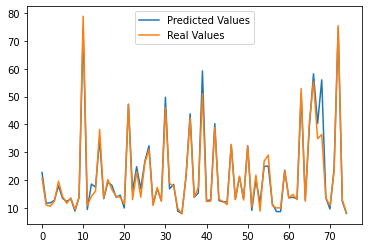

In [ ]:
# Extract the predictions and the target labels.
predictions = pred.select("prediction").rdd.map(lambda x: x[0])
labels = pred.select("total_amount").rdd.map(lambda x: x[0])
# Zipping them together
predictionAndLabel = predictions.zip(labels).collect()
x_values=[]
y_values=[]
for prediction in predictionAndLabel:
    x_values.append(prediction[0])
    y_values.append(prediction[1]) 
# Creating data
x = x_values[:75]
y = y_values[:75]
# Plotting lines
plt.plot(x, label="Predicted Values")
plt.plot(y, label="Real Values")
plt.legend()
plt.show()

In [ ]:
#Viewing only target and prediction
pred.select("total_amount", "prediction").show()

+------------+------------------+
total_amount| prediction|
+------------+------------------+
 20.76| 22.69769019475196|
 11.0|11.661528590289711|
 10.56|11.772224797328864|
 12.36|12.672541002085913|
 19.56|17.921594052729525|
 14.0|13.374236406095436|
 11.62|12.312326257738373|
 13.56| 13.2089994490805|
 9.36| 8.808761058334392|
 13.8| 13.7745160238031|
 78.88| 74.61566376060597|
 10.8| 9.393053533433282|
 14.12|18.525955694441137|
 15.96|17.446845561986354|
 38.16| 34.85903280983365|
 13.44|13.275798495867269|
 20.16|19.235992222025896|
 16.56| 18.04661138151805|
 14.16|13.809388721293393|
 13.8|14.506120830339311|
+------------+------------------+
only showing top 20 rows